In [140]:
%load_ext autoreload
%autoreload 2
from lib.preamble import *

%matplotlib widget
import warnings

data = []

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from skimage.registration import phase_cross_correlation
def find_shift(d: xr.DataArray):
	shift = []
	for i in range(len(d)-1):
		shift.append(phase_cross_correlation(d[i], d[i+1])[0])
	return np.array(shift)

# Import Data

In [141]:
# import backgrounds
paths = glob("../data/2023-12-05*/d*.asc")
paths += glob("../data/2023-12-06*/d*.asc")
paths += glob("../data/2023-12-07*/d*.asc")
paths += glob("../data/2023-12-12*/d*.asc")
paths += glob("../data/2023-12-13*/d*.asc")
paths += glob("../data/2023-12-14*/d*.asc")
paths += glob("../data/2023-12-19*/d*.asc")
paths += glob("../data/2023-12-20*/d*.asc")
paths += glob("../data/2023-12-21*/d*.asc")
paths += glob("../data/2023-12-22*/d*.asc")
paths += glob("../data/2024-01-09*/d*.asc")
paths = [p for p in paths if "bkg" in p]
paths.sort()

import csv

def _read_csv(path):
	rows = []
	with open(path) as f:
		r = csv.reader(f, delimiter="\t")
		for row in r:
			if len(row) == 0:
				return rows
			rows.append(row)
	return rows

def custom_import_spectra(p):
	d = np.array(_read_csv(p))[:, :-1]
	# convert strings to floats
	d = d.astype(float)

	ar = xr.DataArray(
		d[:, 1],
		coords={
			'wavelength': d[:, 0]
		}
	)

	# get the metadata
	number, exposure = p.replace(".", "_").split("s")[0].split("_")[-1].split("x")

	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": p.split("data/")[-1].split(".")[0],
		"number": int(number),
		"exposure": float(exposure),
	}
	ar.name = ar.attrs["name"]
	
	return ar

bkg = [custom_import_spectra(p) for p in paths]
bkg_new = bkg.copy()

bkg[0] = bkg[0] / 3
bkg[1] = bkg[1] / 3
bkg[2] = bkg[2] / 5

import difflib

def background_substract_old(sel, b=None):
	if b is np.nan:
		return None
	if b is None:		
		same_folder = [b for b in bkg if sel.name.split("/")[0] in b.name]
		if len(same_folder) == 1: b=same_folder[0]
		elif len(same_folder) > 1:
			b_name = difflib.get_close_matches(sel, [b.name for b in same_folder], n=1, cutoff=0)[0]
			b = [b for b in same_folder if b.name == b_name][0]
		else:
			before = [b for b in bkg if b.name < sel.name]
			if before:
				b = sorted(before, key=lambda x: x.name)[-1]
			else:
				b = sorted(bkg, key=lambda x: x.name)[0]
	
	d =  sel - b.interp(wavelength=sel.wavelength, kwargs={"fill_value": np.nan})
	d.attrs = sel.attrs
	d.name = sel.name
	d.attrs["background"] = b

	d = d.dropna("wavelength")

	d /= d.attrs["number"]
	d /= d.attrs["exposure"]

	return d


bkg = bkg_new

# create a script that
def background_substract(sel, b=None):
	if b is not None:
		return background_substract_old(sel, b)
	
	exposure = sel.attrs["exposure"]
	wavelength = (sel.wavelength.min(), sel.wavelength.max())

	# get all backgrounds with the same exposure
	same_exposure = [b for b in bkg if b.attrs["exposure"] == exposure]

	# find the same wavelength
	same_wavelength = [b for b in same_exposure if b.wavelength.min() <= wavelength[0] and b.wavelength.max() >= wavelength[1]]

	# if there is only one, use it
	if len(same_wavelength) == 1: b=same_wavelength[0]

	# if there are more, use the one with the closest wavelength
	elif len(same_wavelength) > 1:
		b_name = difflib.get_close_matches(sel, [b.name for b in same_wavelength], n=1, cutoff=0)[0]
		b = [b for b in same_wavelength if b.name == b_name][0]
	
	else:
		# check if there is a partial match of the wavelength
		partial_match = [b for b in same_exposure if b.wavelength.min() <= wavelength[0] or b.wavelength.max() >= wavelength[1]]
		if len(partial_match) == 1: b=partial_match[0]
		
		# take the closest one
		elif len(partial_match) > 1:
			# b_name = difflib.get_close_matches(sel, [b.name for b in partial_match], n=1, cutoff=0)[0]
			# b = [b for b in partial_match if b.name == b_name][0]
			b = sorted(partial_match, key=lambda x: np.abs(x.wavelength.mean() - sel.wavelength.mean()))[0]
		
		else:
			warnings.warn(f"no background found for {sel.name}")
			return sel
	
	return background_substract_old(sel, 
		b * sel.attrs["number"] / b.attrs["number"]
	)


pprint([b.name for b in bkg])

['2023-12-05_LO_MG_NiPS3/d001_bkg_15x5s',
 '2023-12-07_LO_MG_NiPS3/d003_bkg_15x5s',
 '2023-12-13_CrPS4_outPlane/d001_bkg_25x5s_horPol',
 '2023-12-14_CrPS4_outPlane/d002_bkg_25x3s',
 '2023-12-14_CrPS4_outPlane/d008_bkg_25x10s',
 '2023-12-20_NiPS3_inPlane/d002_bkg_10x10s',
 '2023-12-20_NiPS3_inPlane/d005_bkg_25x5s_smaller_slit',
 '2023-12-21_NiPS3_inPlane/d001_bkg_10x10s',
 '2023-12-22_NiPS3_inPlane/d001_bkg_5x5s',
 '2024-01-09_NiPS3_inPlane/d002_bkg_5x10s']


In [142]:
# import data from the 2023-12-05 done with normal scanning script
import h5py

paths = glob("../data/2023-12-05*/*hd5.h5")
paths += glob("../data/2023-12-06*/*hd5.h5")
paths.sort()

def import_files(p):
	try:
		with h5py.File(p, "r") as f:
			field = np.array(f["data_full"]["magnet"]["field"])
			wavelength = np.array(f["x"])
			counts = np.array(f["z"])
			angle = np.array(f["data_full"]["apt"][
				list(f["data_full"]["apt"].keys())[0]
			]["position"])
   
			exposure = f["data_full"]["spectrometer"]["exposure"][0]
			number = f["data_full"]["spectrometer"]["number"][0]
   
			counts = counts / number / exposure
	except:
		print(f"Error importing:\t{p}")
		return None

	unique_angles = np.unique(angle)
	counts = counts.reshape(field.shape[0]//len(unique_angles), len(unique_angles), -1)
	field = field[::len(unique_angles)]

	multiple_fields = (field.shape[0] == 1)

	ar = xr.DataArray(
		counts,
		coords={
			"field": field,
			"angle": unique_angles,
			"wavelength": wavelength[0],
		},
	)
	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": ".".join(p.split("data/")[-1].split(".")[:-1]),
		"multiple_fields": multiple_fields,
		"exposure": exposure,
		"number": number,
	}
	ar.name = ar.attrs["name"]


	diff_field = np.diff(ar.field)
	if np.all(diff_field > 0):
		ar.attrs["field_direction"] = 1.
	elif np.all(diff_field < 0):
		ar.attrs["field_direction"] = -1.
	else:
		ar.attrs["field_direction"] = np.nan

	return ar

data_import = [import_files(p) for p in paths]
data_import = [background_substract_old(d) for d in data_import if d is not None]
data = [d for d in data if d.name not in [d.name for d in data_import]]
data += data_import

In [135]:
# import all from 2023-12-06 and 07 done with custom script
import h5py

paths = glob("../data/2023-12-05*/*hd5.h5")
paths += glob("../data/2023-12-06*/*.h5")
paths += glob("../data/2023-12-07*/*.h5")
paths += glob("../data/2023-12-08*/*.h5")
paths += glob("../data/2023-12-11*/*.h5")
paths += glob("../data/2023-12-12*/*.h5")
paths += glob("../data/2023-12-13*/*.h5")
paths += glob("../data/2023-12-14*/*.h5")
paths += glob("../data/2023-12-15*/*.h5")
paths += glob("../data/2023-12-18*/*.h5")
paths += glob("../data/2023-12-19*/*.h5")
paths += glob("../data/2023-12-20*/*.h5")
paths += glob("../data/2023-12-21*/*.h5")
paths += glob("../data/2023-12-22*/*.h5")
paths += glob("../data/2024-01-09*/*.h5")
paths += glob("../data/2024-02-14*/*.h5")
paths += glob("../data/2024-02-15*/*.h5")
paths += glob("../data/2024-02-16*/*.h5")
paths.sort()

# paths = list(filter(lambda p: "hd5" not in p, paths))

def import_custom_script(p):
	with h5py.File(p, "r") as f:
		angle_count = len(np.unique(f['apt_angle']))

		if "magnet_field" in f:
			field = f["magnet_field"][::angle_count]
		else:
			field = np.array([np.nan])

		angle = f["apt_angle"][:angle_count]
		wavelength = f["wavelength"][0]
		counts = f["counts"][:].reshape(field.shape[0], angle.shape[0], wavelength.shape[0])

		time = f["time"][:].reshape(field.shape[0], angle.shape[0])

		if "temperature" in f:
			temperature = f["temperature"][:].reshape(field.shape[0], angle.shape[0])
		else:
			temperature = np.full_like(time, np.nan)

		if "position" in f:
			position = f["position"][:].reshape(field.shape[0], angle.shape[0], 3)
		else:
			position = np.full_like(counts, np.nan)

		exposure = f["data_full"]["spectrometer"]["exposure"][0]
		number = f["data_full"]["spectrometer"]["number"][0]

	ar = xr.DataArray(
		counts,
		dims=["field", "angle", "wavelength"],
		coords={
			"field": field,
			"angle": angle,
			"wavelength": wavelength,
		},
		attrs={
			"exposure": exposure,
			"number": number,
		}
	)

	# add coord time
	ar.coords["time"] = (
		["field", "angle"],
		time
	)

	# add coord temperature
	ar.coords["temperature"] = (
		["field", "angle"],
		temperature
	)

	return ar

def import_files(p):

	try:
		ar = import_custom_script(p)
	except:
		print(f"Error importing:\t{p}")
		return None

	# if ar is None:
		# return None
	
	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": ".".join(p.split("data/")[-1].split(".")[:-1]),
	}
	ar.name = ar.attrs["name"]


	diff_field = np.diff(ar.field)
	if np.all(diff_field > 0):
		ar.attrs["field_direction"] = 1.
	elif np.all(diff_field < 0):
		ar.attrs["field_direction"] = -1.
	else:
		ar.attrs["field_direction"] = np.nan

	return ar

data_import = [import_files(p) for p in paths]
data_import = [d for d in data_import if d is not None]
data_import = [background_substract(d) for d in data_import]
data = [d for d in data if d.name not in [d.name for d in data_import]]
data += data_import

Error importing:	../data/2023-12-05_LO_MG_NiPS3/d004_10K_647nm_rotPolDet_26degPolExc_flake04.hd5.h5
Error importing:	../data/2023-12-06_LO_MG_NiPS3/d001_50K_647nm_rotPolDet_flake04_sweepUp_inPlane.hd5.h5
Error importing:	../data/2023-12-06_LO_MG_NiPS3/d002_10K_647nm_rotPolDet_flake04_sweepDown_inPlane.hd5.h5
Error importing:	../data/2023-12-06_LO_MG_NiPS3/d003_pol_10K_flake05.hd5.h5
Error importing:	../data/2023-12-06_LO_MG_NiPS3/d004_10K_647nm_rotPolDet_flake05_sweepDown_inPlane.hd5.h5
Error importing:	../data/2024-02-15 CrPS4 outPlane linPolExc linPolDet/d002_45K.hd5.h5
Error importing:	../data/2024-02-15 CrPS4 outPlane linPolExc linPolDet/d003_5K.hd5.h5


/tmp/ipykernel_306383/1401868505.py:128: UserWarning: no background found for 2024-02-14 CrPS4 outPlane linPolExc linPolDet/d001_280K.hd5_6
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_306383/1401868505.py:128: UserWarning: no background found for 2024-02-14 CrPS4 outPlane linPolExc linPolDet/d002_100K.hd5_4
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_306383/1401868505.py:128: UserWarning: no background found for 2024-02-15 CrPS4 outPlane linPolExc linPolDet/d001_70K.hd5_5
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_306383/1401868505.py:128: UserWarning: no background found for 2024-02-15 CrPS4 outPlane linPolExc linPolDet/d002_45K.hd5_1
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_306383/1401868505.py:128: UserWarning: no background found for 2024-02-15 CrPS4 outPlane linPolExc linPolDet/d003_5K.hd5_1
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_306383/1401868

In [136]:
# add energy coordinates
data = [d.assign_coords(energy=1239.84193/d.wavelength) for d in data]

# Preliminary analysis

In [137]:
{i: d.name for i, d in enumerate(data) if "mirror" in d.name.lower()}

{}

In [138]:
i_sel = -1
sel = data[i_sel]
sel.name

'2024-02-16 CrPS4 inPlane linPolExc linPolDet/d002_30K_hysteresis.hd5_3'

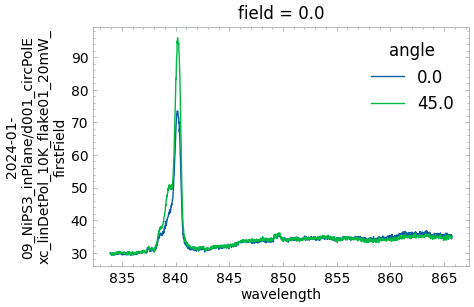

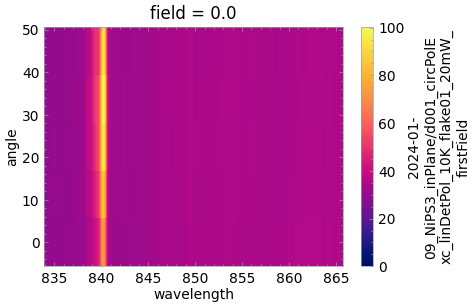

0.0170321466476821
0.18749720198197595


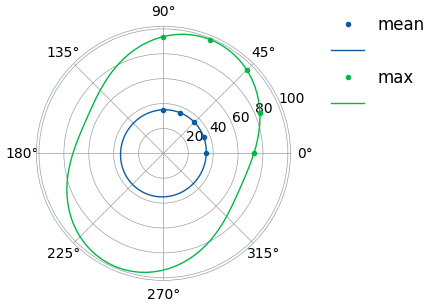

In [45]:
# sel = data[i_sel]

plt.figure()
sel.isel(field=0, angle=[0, -1]).plot.line(
	x="wavelength",
	# add_legend=False,
	# _labels={},
)
plt.show()

plt.figure()
sel.isel(field=0).plot(cmap=cm["CET_L8"], vmin=0)
plt.show()

def pre(d):
	# .sel(wavelength=slice(435, 845)).mean("wavelength")\
	return d.isel(field=0)\
	.rolling(wavelength=10).mean()\
	.assign_coords(angle=sel.angle*np.pi/180 *2)

plt.figure()
ax = plt.subplot(111, projection="polar")

for s in [
	pre(sel).mean("wavelength"),
	pre(sel).max("wavelength"),

]:

	markers = s.plot(
		ax=ax,
		linestyle="none",
		marker="o",
		_labels={}
	)

	# make fit and show
	popt, pcov = fit_cos_sqr(sel.angle*2, 
		s.values,
	)
	angle = np.linspace(0, 360, 100)
	ax.plot(angle*np.pi/180, cos_sqr(angle, *popt), label="fit",
		color=markers[0].get_color(),		
	)
	print(polarisation_degree(popt))

plt.legend(["mean", None, "max", None], bbox_to_anchor=(1.1, 1.1))

plt.show()

In [46]:
{i:s.name for i,s in enumerate(data) if "2023-12-19" in s.name or "2023-12-20" in s.name}

{30: '2023-12-19_NiPS3/d002_circPolExc_linDetPol_50K_flake08_1mW',
 31: '2023-12-19_NiPS3/d003_circPolExc_linDetPol_50K_flake07_2.2mW',
 32: '2023-12-19_NiPS3/d004_circPolExc_linDetPol_50K_flake02_1.9mW',
 33: '2023-12-19_NiPS3/d005_circPolExc_linDetPol_5K_flake02_2mW',
 34: '2023-12-19_NiPS3/d006_circPolExc_linDetPol_5K_flake07_2mW',
 35: '2023-12-19_NiPS3/d006c_circPolExc_linDetPol_5K_flake07_2mW',
 36: '2023-12-19_NiPS3/d007_circPolExc_linDetPol_5K_flake08_2mW',
 37: '2023-12-20_NiPS3_inPlane/d001_circPolExc_linDetPol_10K_flake02_2mW',
 38: '2023-12-20_NiPS3_inPlane/d003_circPolExc_linDetPol_10K_flake02_2mW_smallerSlit',
 39: '2023-12-20_NiPS3_inPlane/d005_circPolExc_linDetPol_10K_flake08_2mW_smallerSlit_filmBeamsplitter',
 40: '2023-12-20_NiPS3_inPlane/d006_circPolExc_linDetPol_10K_flake08_2mW_smallerSlit'}

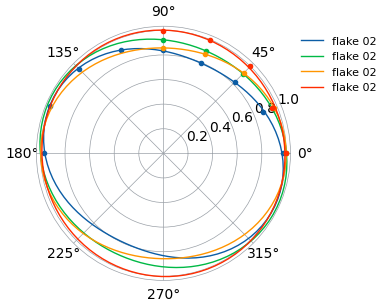

In [47]:
plt.figure()
ax = plt.subplot(111, projection="polar")

sel_mult = np.array(data, dtype="object")[[38, 36, 35, 32]]

def pre(d):
	# .sel(wavelength=slice(435, 845)).mean("wavelength")\
	d = d.isel(field=0)\
	.sel(wavelength=slice(838, 842))\
	.rolling(wavelength=15).mean().max("wavelength")\
	.assign_coords(angle=sel.angle*np.pi/180 *2)
	return d / d.max()

sel_mult = [s for i,s in enumerate(data) if ("2023-12-19" in s.name or "2023-12-20" in s.name) and "flake02" in s.name]

for sel in sel_mult:

	markers = pre(sel).plot(
		ax=ax,
		linestyle="none",
		marker="o",
		_labels={}
	)

	# make fit and show
	popt, pcov = fit_cos_sqr(sel.angle*2, 
		pre(sel).values,
	)
	angle = np.linspace(0, 360, 100)
	ax.plot(angle*np.pi/180, cos_sqr(angle, *popt),
		color=markers[0].get_color(),
		label="flake " + sel.name.split("flake")[-1].split("_")[0],
		# label=sel.name
	)
plt.legend(
	bbox_to_anchor=(1.0, 1.0),
	fontsize=FONTSIZE_TINY
)
plt.show()

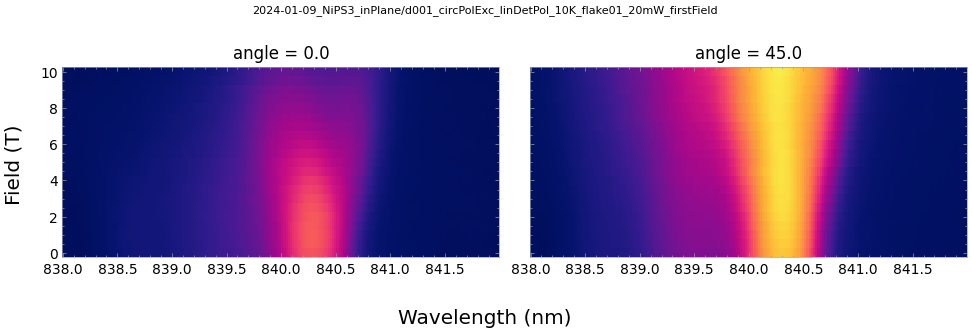

In [48]:
sel = data[i_sel]
wavelength_slice = slice(None, None)
# wavelength_slice = slice(908, 918)
wavelength_slice = slice(838, 842)
# angles = sel.angle
angles = [0, 45]

# sel = sel/sel.mean("wavelength")
sel = sel.rolling(wavelength=10).mean()
sel = sel.sel(wavelength=wavelength_slice)

sel = sel.sortby("field")

assert len(sel.field) > 1, "multiple field measurements needed"

fig, axs = plt.subplots(1, len(angles), sharex=True, sharey=True, figsize=FIGSIZE_WIDE)
fig.suptitle(sel.name)
for ang, ax in zip(angles, axs):
	img = sel.sel(angle=ang).plot(
		ax=ax, 
		cmap=cm["CET_L8"],
		vmin=sel.min(),
		vmax=sel.max(),
		add_colorbar=False
	)
	# ax.set_title("")
	ax.set_xlabel("")
	ax.set_ylabel("")

for ax in axs[1:]:
	ax.set_ylabel("")

# plt.colorbar(img)

fig.supxlabel("Wavelength (nm)")
fig.supylabel("Field (T)")
# plt.savefig(f"../figures/2023-12-06_{sel.name.replace('/', '_')}.png")
plt.show()

In [49]:
{i:d.name for i,d in enumerate(data) if "NiPS3" in d.name}

{0: '2023-12-05_LO_MG_NiPS3/d004_10K_647nm_rotPolDet_26degPolExc_flake04.hd5',
 1: '2023-12-06_LO_MG_NiPS3/d001_50K_647nm_rotPolDet_flake04_sweepUp_inPlane.hd5',
 2: '2023-12-06_LO_MG_NiPS3/d002_10K_647nm_rotPolDet_flake04_sweepDown_inPlane.hd5',
 3: '2023-12-06_LO_MG_NiPS3/d003_pol_10K_flake05.hd5',
 4: '2023-12-06_LO_MG_NiPS3/d004_10K_647nm_rotPolDet_flake05_sweepDown_inPlane.hd5',
 5: '2023-12-06_LO_MG_NiPS3/d005_script_test',
 6: '2023-12-06_LO_MG_NiPS3/d006_flake01_10K_inPlane_linPol',
 7: '2023-12-07_LO_MG_NiPS3/d001_flake06_50K_inPlane_linPol',
 8: '2023-12-07_LO_MG_NiPS3/d002_flake04_50K_inPlane_linPol_sweepDown',
 9: '2023-12-07_LO_MG_NiPS3/d005_flake04_50K_inPlane_linPol_sweepUp',
 10: '2023-12-07_LO_MG_NiPS3/d006_flake04_50K_inPlane_linPol_sweepDown',
 11: '2023-12-08_LO_MG_NiPS3/d001_flake04_50K_inPlane_linPol_sweepUp',
 12: '2023-12-08_LO_MG_NiPS3/d002_flake04_50K_inPlane_linPol_hysteresis',
 13: '2023-12-11_NiPS3/d001_flake06_50K_circPol',
 14: '2023-12-11_NiPS3/d002_flak

/home/leon/Projekte/Studium/2023_WS/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84187/ev


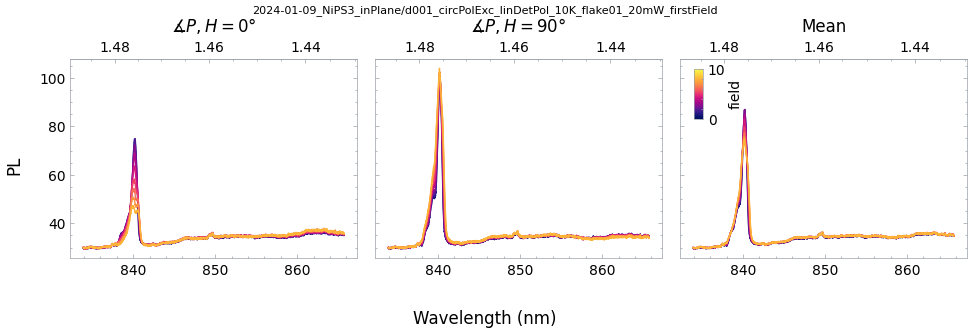

In [50]:
sel = data[i_sel]
# sel = data[6]
wavelength_slice = slice(None, None)
# wavelength_slice = slice(839, 841)

# angles = sel.isel(angle=[0, -1]).angle
angles = [0, 45]
fig, axs = plt.subplots(1, len(angles)+1, sharex=True, sharey=True, figsize=FIGSIZE_WIDE)

def pre(d):
	d = monotonic_sections_axis(d, "field")[0]
	d = d.\
	rolling(wavelength=1).mean().\
	rolling(field=2).mean().\
	sortby("field")
	# return d
	return d.sel(wavelength=wavelength_slice)

field = np.linspace(0, sel.field.max(), 10)
color = cm["CET_L8"](field / field.max() * 0.8)

for ang, ax in zip(angles, axs):
	for f, c in zip(field, color):
		pre(sel).sel(angle=ang).interp(field=f).plot(
			ax=ax, 
			color=c,
			x="wavelength",
		)
	ax.set_title(fr"$\measuredangle P,H = {float(ang)*2:.0f}°$")
	ax.set_xlabel("")
	ax.set_ylabel("")
	plot.energy_ticks(ax)

ax = axs[-1]
for f, c in zip(field, color):
	pre(sel).sel(angle=angles).mean("angle").interp(field=f).plot(
		ax=ax, 
		color=c,
		x="wavelength",
	)
ax.set_title("Mean")
ax.set_xlabel("")
ax.set_ylabel("")
plot.energy_ticks(ax)


fig.supxlabel("Wavelength (nm)", fontsize=FONTSIZE)
fig.supylabel("PL", fontsize=FONTSIZE)

# add colorbar with field
sm = plt.cm.ScalarMappable(cmap=cm["CET_L8"], norm=plt.Normalize(vmin=0, vmax=field.max()))
cax = axs[-1].inset_axes([0.05, 0.7, 0.03, 0.25])
fig.colorbar(sm, cax=cax, label=r"field")
plt.tight_layout()
plt.suptitle(sel.name)

# plt.savefig(f"../report/figures/2023-12-10 splitting quantified.pdf")
plt.show()

In [51]:
{i:d.name for i ,d in enumerate(data) if "Cr" in d.name and "linPolDet" in d.name}

{17: '2023-12-13_CrPS4_outPlane/d002_linPolDet_50K',
 18: '2023-12-13_CrPS4_outPlane/d004_linPolDet_circExcPol_50K_3x3s_flake01',
 19: '2023-12-13_CrPS4_outPlane/d005_linPolDet_circExcPol_50K_3x3s_flake02',
 20: '2023-12-13_CrPS4_outPlane/d006_linPolDet_circExcPol_50K_3x3s_flake03',
 25: '2023-12-14_CrPS4_outPlane/d005_linPolDet_circExcPol_10K_flake01_0.6mW',
 26: '2023-12-14_CrPS4_outPlane/d007_linPolDet_circExcPol_10K_flake03_3.3mW',
 28: '2023-12-15_CrPS4_inPlane/d001_linPolDet_circExcPol_10K_flake03_4mW'}

In [52]:
i_sel = [i for i,d in enumerate(data) if "Cr" in d.name and "linPolDet" in d.name][-1]

In [53]:
[d.name for i,d in enumerate(data) if "Ni" in d.name and "linDetPol" in d.name]

['2023-12-19_NiPS3/d002_circPolExc_linDetPol_50K_flake08_1mW',
 '2023-12-19_NiPS3/d003_circPolExc_linDetPol_50K_flake07_2.2mW',
 '2023-12-19_NiPS3/d004_circPolExc_linDetPol_50K_flake02_1.9mW',
 '2023-12-19_NiPS3/d005_circPolExc_linDetPol_5K_flake02_2mW',
 '2023-12-19_NiPS3/d006_circPolExc_linDetPol_5K_flake07_2mW',
 '2023-12-19_NiPS3/d006c_circPolExc_linDetPol_5K_flake07_2mW',
 '2023-12-19_NiPS3/d007_circPolExc_linDetPol_5K_flake08_2mW',
 '2023-12-20_NiPS3_inPlane/d001_circPolExc_linDetPol_10K_flake02_2mW',
 '2023-12-20_NiPS3_inPlane/d003_circPolExc_linDetPol_10K_flake02_2mW_smallerSlit',
 '2023-12-20_NiPS3_inPlane/d005_circPolExc_linDetPol_10K_flake08_2mW_smallerSlit_filmBeamsplitter',
 '2023-12-20_NiPS3_inPlane/d006_circPolExc_linDetPol_10K_flake08_2mW_smallerSlit',
 '2023-12-21_NiPS3_inPlane/d002_circPolExc_linDetPol_50K_flake01_1mW',
 '2023-12-22_NiPS3_inPlane/d002_circPolExc_linDetPol_5K_flake01_1mW',
 '2024-01-09_NiPS3_inPlane/d001_circPolExc_linDetPol_10K_flake01_20mW_firstField

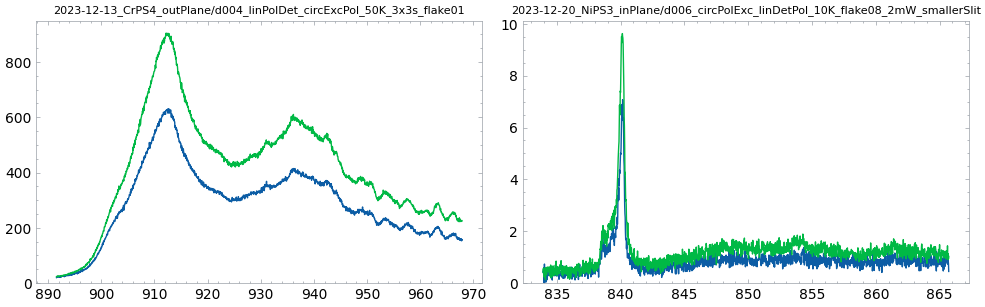

In [59]:
sel = data[i_sel]
# sel = data[6]
wavelength_slice = slice(None, None)
# wavelength_slice = slice(839, 841)

def pre(d):
    return d.isel(field=0).sel(wavelength=wavelength_slice)

def plot(sel):
    pre(sel).sel(angle=0).plot(_labels=False)
    pre(sel).sel(angle=45).plot(_labels=False)
    plt.title(sel.name, fontsize=FONTSIZE_TINY)
    plt.ylim(0, None)
    return plt.gca()

plt.figure(figsize=FIGSIZE_WIDE)
plt.subplot(121)
# plt.locator_params(nbins=5)
plot([d for i,d in enumerate(data) if "Cr" in d.name and "linPolDet" in d.name][1])
plt.subplot(122)
plot([d for i,d in enumerate(data) if "Ni" in d.name and "linDetPol" in d.name][10])

plt.show()

## Linear Polarisation

In [55]:
%%time
sel = data[-1]
# sel = monotonic_sections_axis(sel, "field")[1]
# sel = sel / sel.mean(["wavelength", "angle"])
# sel = (data[-1] + data[-1].background.interp(wavelength=data[-1].wavelength))
# sel = (sel - sel.min())
assert len(sel.angle) > 3
# sel = xr.concat((data[34], data[35]), dim="field")
# sel = sel.sortby("field")

# wavelength_slice = slice(None, None)
# wavelength_slice = slice(830, 850)
# wavelength_slice = slice(838, 842)
wavelength_slice = slice(839, 841)
# angles = sel.angle
# sel = sel.rolling(wavelength=5).mean()
sel = sel.sel(wavelength=wavelength_slice)

def custom_polarisation(sel, bins=40):
	sel = sel.where(~np.isnan(sel), drop=True)
	sel = sel.coarsen(wavelength=sel.wavelength.shape[0]//bins, boundary="trim").mean()
	pol = polarisation_xarray(sel.assign_coords(angle=2*sel.angle), fast=False)
	pol = pol.sortby("field")
	return pol


pol = custom_polarisation(sel)

TypeError: polarisation_xarray() got an unexpected keyword argument 'fast'

In [ ]:
fig = plt.figure(figsize=FIGSIZE_WIDE)
plt.suptitle(sel.name)

plt.subplot(131)
img = sel.sortby("field").mean("angle").plot(
	vmin=0,
	add_labels=False, 
	add_colorbar=False,
	cmap=cm["CET_L8"],
)
plt.colorbar(img)
plt.title(r"PL all Polarisations")

plt.subplot(132)
norm = mpl.colors.LogNorm()
pol.polarisation.plot(
	# vmin=0,
	add_labels=False,
	cmap=cm["CET_L8"],
	norm=norm
)
plt.title("Polarisation")

ax = plt.subplot(133)
ax.set_facecolor("k")
img = (
	pol.angle
).plot(
	vmin=0, vmax=180,
	cmap=cm["CET_C6s"],
	# cmap=cm["colorwheel"],
	add_labels=False,
	add_colorbar=False,
	# alpha=(pol.polarisation/pol.polarisation.max())**(1/10)
	# alpha=norm(pol.polarisation)**(1/2)
	alpha=1- (pol.angle_uncert/pol.angle_uncert.max())**(1/2)
	# alpha = np.where(pol.angle_uncert<10, 1, 0)
)
plt.colorbar(img).ax.set_yticks(np.arange(0, 181, 45))
plot.inset_cbar_polar(cmap=img.cmap)

plt.title("Polarisation angle")

fig.supxlabel("Wavelength (nm)", fontsize=FONTSIZE)
fig.supylabel("Field (T)", fontsize=FONTSIZE)

# plt.savefig(f"../figures/2023-12-06 polarisation {sel.name.replace('/',  ' ')}.png")
plt.show()

In [ ]:
plt.figure()
def pre(d):
	return d
	# return np.cos(d * np.pi / 180)
pre(pol.angle).mean("wavelength").plot(label="Mean Pol")
pre(pol.angle).interp(wavelength=sel.idxmax("wavelength").mean()).plot(label="Pol at PL peak")
plt.legend()
plt.show()

In [ ]:
plt.figure()
def pre(d):
	return d
	# return np.cos(d * np.pi / 180)
pre(pol.polarisation).mean("wavelength").plot(label="Mean Pol")
pre(pol.polarisation).interp(wavelength=sel.idxmax("wavelength").mean()).plot(label="Pol at PL peak")
plt.ylim(0, None)
plt.legend()
plt.show()

## Circular Polarisation

In [ ]:
# plot the circular dichroism
sel = data[-1]
assert len(sel.angle) == 2

wavelength_slice = slice(None, None)

def pre(d):
	return d.rolling(wavelength=1).mean()\
	.sel(wavelength=wavelength_slice)\
	.sortby("field")

fig = plt.figure(figsize=FIGSIZE_WIDE)
ax = plt.subplot(121)
pre(sel).mean("angle").plot(
	cmap=cm["CET_L8"],
	add_labels=False
)
plt.title("PL")

ax = plt.subplot(122, sharex=ax, sharey=ax)
dichroism(pre(sel)).plot(
	cmap=cm["CET_D1"],
	# cmap=cm["CET_L8"],
	# vmin=0,
	add_labels=False,
)
plt.title("Circular Dichroism")

fig.supxlabel("Wavelength (nm)", fontsize=FONTSIZE)
fig.supylabel("Field (T)", fontsize=FONTSIZE)

# plt.savefig(f"../figures/2023-12-06 circular dichroism {sel.name.replace('/',  ' ')}.png")

plt.show()

## Random Stuff

In [ ]:
sel = data[-1]

plt.figure()

# plt.plot(sel.time,
# 	dichroism(sel).mean("wavelength"))

plt.plot(
	(sel.time - sel.time[0])/60/60,
	sel.mean("wavelength")
)
plt.ylabel("Mean Counts")

plt.xlabel("Time (h)")

ax = plt.gca().twinx()
ax.plot(
	(sel.time - sel.time[0])/60/60,
	sel.field,
	color='red',
)
ax.tick_params(axis='y', labelcolor="red")
plt.ylabel("Field out of plane")

# plt.savefig(f'../figures/2023-12-14 stability {sel.name.replace("/", " ")}.png')

plt.show()

In [ ]:
plt.figure()
# sel.sel(wavelength=wavelength_slice).mean("wavelength").mean("angle").plot()

wavelength_max = sel.mean(["field", "angle"]).idxmax("wavelength")
pol.polarisation.sel(
	wavelength=slice(wavelength_max-1, wavelength_max+1)
).mean("wavelength").plot(
	label="max intensity",
)

plt.legend()
plt.suptitle(sel.name)
plt.title("")
plt.show()

# NiPS3

## PL intensity

In [143]:
# extract mean pl disregarding polarisation
sel = [
	data[12],
	data[1],
	data[2],
	data[4],
	data[9],
	data[6],	# flake01
	data[8],
	data[10],
	# data[11], # focused on 0T but moved from 10T
]

def prepare_for_plot(d: xr.DataArray):
	return \
	unploarized(d)\
	.rolling(wavelength=10).mean()\
	.sel(wavelength=wavelength_slice).max("wavelength")

plt.figure()
for s in sel:
	if s.field_direction is not np.nan:
		(prepare_for_plot(s)/prepare_for_plot(s).sel(field=0))\
		.plot(
			linestyle="dashed" if s.field_direction>0 else "dotted",
			# label="up" if s.field_direction>0 else "down"
			label= (r"$\rightarrow$" if s.field_direction>0 else r"$\leftarrow$")\
			+ ", flake" + s.name.split("flake")[-1].split("_")[0]\
			+ ", " + s.name.split("K_")[0].split("_")[-1] + "K",
			alpha=.5
		)
	else:
		(prepare_for_plot(s)/prepare_for_plot(s).min("field"))\
		.plot(
			label=r"$\leftrightarrow$"\
			+ ", flake" + s.name.split("flake")[-1].split("_")[0]\
			+ ", " + s.name.split("K_")[0].split("_")[-1] + "K"
		)

plt.legend(fontsize=FONTSIZE_TINY)
plt.ylabel(r"PL$_{\text{max}\;\lambda}$, unpolarized")
plt.xlabel(r"$H_\text{in plane}$ (T)")
plt.savefig("../report/figures/2023-12-10 lens movement.pdf")
plt.show()

IndexError: list index out of range

## Spectra / Splitting

In [139]:
sel =  [d for d in data if "Ni" in d.name and "inPlane" in d.name and ("linPol" in d.name or "linDet" in d.name)]
pprint({i:d.name for i,d in enumerate(sel)})
sel = sel[9]
pprint(sel.name)
sel = sel.where(~np.isnan(sel), drop=True)
# wavelength_slice = slice(None, None)
# wavelength_slice = slice(837, 843)
wavelength_slice = slice(839, 841)
wavelength_slice_norm = slice(846, 860)
angles = [0, 45]

{0: '2023-12-06_LO_MG_NiPS3/d006_flake01_10K_inPlane_linPol',
 1: '2023-12-07_LO_MG_NiPS3/d001_flake06_50K_inPlane_linPol',
 2: '2023-12-07_LO_MG_NiPS3/d002_flake04_50K_inPlane_linPol_sweepDown',
 3: '2023-12-07_LO_MG_NiPS3/d005_flake04_50K_inPlane_linPol_sweepUp',
 4: '2023-12-07_LO_MG_NiPS3/d006_flake04_50K_inPlane_linPol_sweepDown',
 5: '2023-12-08_LO_MG_NiPS3/d001_flake04_50K_inPlane_linPol_sweepUp',
 6: '2023-12-08_LO_MG_NiPS3/d002_flake04_50K_inPlane_linPol_hysteresis',
 7: '2023-12-11_NiPS3/d003_flake04_50K_linPol_inPlane',
 8: '2023-12-20_NiPS3_inPlane/d001_circPolExc_linDetPol_10K_flake02_2mW',
 9: '2023-12-20_NiPS3_inPlane/d003_circPolExc_linDetPol_10K_flake02_2mW_smallerSlit',
 10: '2023-12-20_NiPS3_inPlane/d005_circPolExc_linDetPol_10K_flake08_2mW_smallerSlit_filmBeamsplitter',
 11: '2023-12-20_NiPS3_inPlane/d006_circPolExc_linDetPol_10K_flake08_2mW_smallerSlit',
 12: '2023-12-21_NiPS3_inPlane/d002_circPolExc_linDetPol_50K_flake01_1mW',
 13: '2023-12-22_NiPS3_inPlane/d002_c

/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84187/ev
/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84187/ev


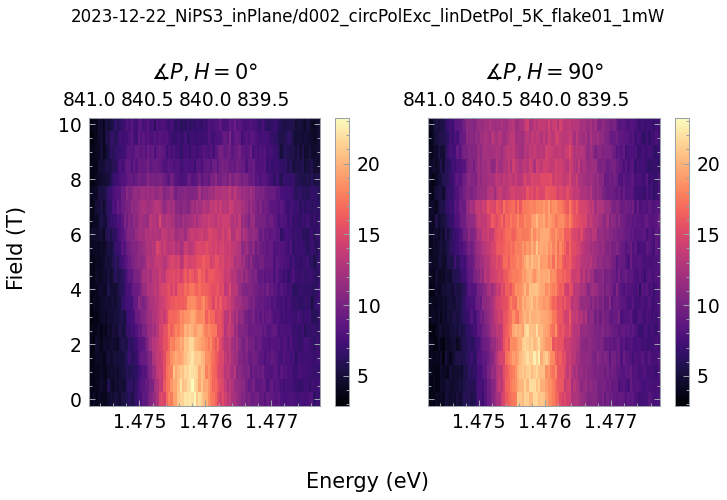

In [76]:
def pre(d):
	# rolling(wavelength=10).mean().\
	d = d.\
	sortby("field")
	return d.sel(wavelength=wavelength_slice) #/ d.sel(wavelength=wavelength_slice_norm).mean("wavelength")

def plot_fig(sel, save=False):

	# get min and max values
	min_sel = pre(sel).sel(angle=angles, method="nearest", tolerance=1).min()
	max_sel = pre(sel).sel(angle=angles, method="nearest", tolerance=1).max()

	fig, axs = plt.subplots(1, len(angles), sharex=True, sharey=True)
	for ang, ax in zip(angles, axs):
		pre(sel).sel(angle=ang, method="nearest", tolerance=1)\
		.plot(
			x="energy",
			y="field",
			ax=ax, 
			cmap=CMAP,
			# levels=20,
			add_colorbar=True,
			add_labels=False,
			vmin=min_sel, vmax=max_sel,
			rasterized=True,
		)
		ax.set_title(fr"$\measuredangle P,H = {float(ang)*2:.0f}°$")
		plot.energy_ticks(ax=ax)

	fig.suptitle(sel.name)
	fig.supxlabel("Energy (eV)", fontsize=FONTSIZE)
	fig.supylabel("Field (T)", fontsize=FONTSIZE)
	if save:
		plt.savefig(f"../report/figures/2023-12-10 splitting.pdf")

	# plt.savefig(f'../figures/2023-12-10 splitting {sel.name.replace("/", " ")}.png')
	return fig

sel_mult = [
	data[2], # nice but wired splitting
	data[4],
	data[6],
	data[10],	# high res but no splitting
]
sel = data[42]
# for s in sel_mult: plot_fig(s)

sel =  [d for d in data if "Ni" in d.name and "inPlane" in d.name and ("linPol" in d.name or "linDet" in d.name)]
pprint({i:d.name for i,d in enumerate(sel)})
sel = sel[9]
pprint(sel.name)


plot_fig(sel, True);
plt.show()

/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84187/ev


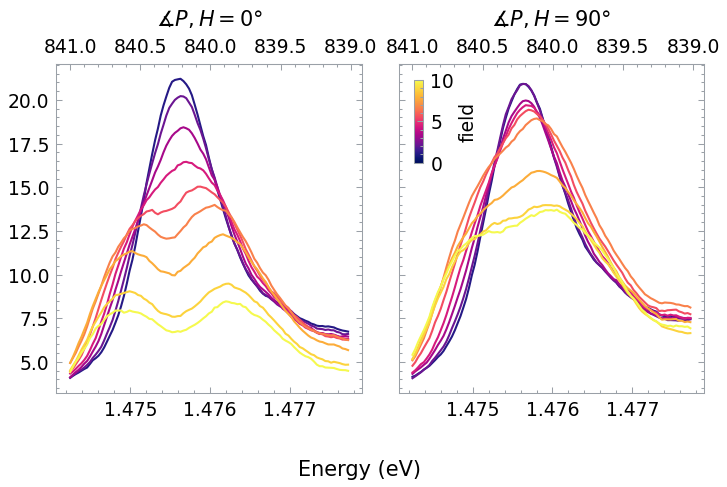

In [16]:
fig, axs = plt.subplots(1, len(angles), sharex=True, sharey=True)

sel = [d for d in data if "Ni" in d.name and "in" in d.name]
sel = sel[-2]

field = np.linspace(0, 10, 10)
color = cm["CET_L8"](field / field.max())

def pre(d):
	d = d.\
	rolling(field=2).mean().\
	rolling(wavelength=10).mean().\
	sortby("field")
	# return d
	return d.sel(wavelength=wavelength_slice) #/ d.sel(wavelength=wavelength_slice_norm).mean("wavelength")

for ang, ax in zip(angles, axs):
	for f, c in zip(field, color):
		pre(sel).sel(angle=ang).interp(field=f).plot(
			ax=ax, 
			color=c,
			x="energy",
		)
	ax.set_title(fr"$\measuredangle P,H = {float(ang)*2:.0f}°$")
	ax.set_xlabel("")
	ax.set_ylabel("")
	plot.energy_ticks(ax)


fig.supxlabel("Energy (eV)", fontsize=FONTSIZE)


# add colorbar with field
sm = plt.cm.ScalarMappable(cmap=cm["CET_L8"], norm=plt.Normalize(vmin=0, vmax=10))
sm.set_array([])
# insert axs for colorbar into axs[-1]
cax = axs[-1].inset_axes([0.05, 0.7, 0.03, 0.25])
fig.colorbar(sm, cax=cax, label=r"field")
plt.tight_layout()

# plt.savefig(f"../report/figures/2023-12-10 splitting quantified.pdf")
plt.show()

In [17]:
print(sel.name)

2023-12-22_NiPS3_inPlane/d002_circPolExc_linDetPol_5K_flake01_1mW


## Polarisation Dependence

### Peanut Plot

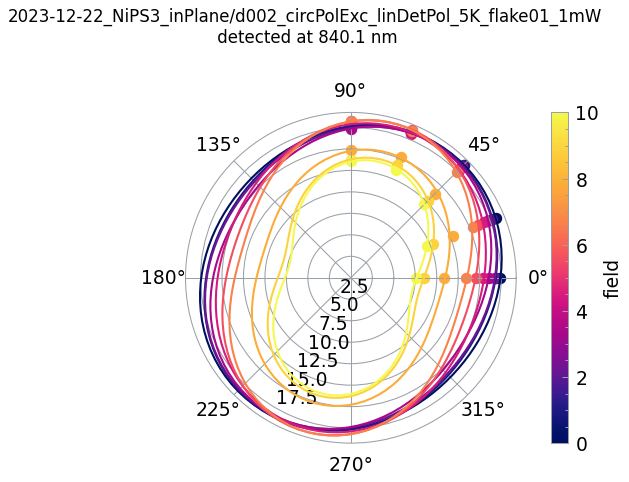

In [9]:
angle_offset = 0

def pre(d):
	d = d.\
	rolling(wavelength=15).mean().\
	sortby("field")
	# return d.sel(wavelength=wavelength_slice).max("wavelength")
	# return d.sel(wavelength=wavelength_slice).mean("wavelength")
	return d.rolling(wavelength=3).mean().sel(wavelength=840.1, method="nearest")

def plot_fig(sel, save=False):
	field = np.linspace(sel.field.min(), sel.field.max(), 10)
	color = cm["CET_L8"](field / field.max())

	fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
	for f, c in zip(field, color):
		pre(sel)\
		.assign_coords(angle=(sel.angle+angle_offset) * np.pi / 180 * 2)\
		.interp(field=f).plot.scatter(
			ax=ax, 
			color=c,
			add_labels=False,
			s=20,
			x="angle",
		)
		popt, pcov = sp.optimize.curve_fit(
			cos_sqr, sel.angle*2, pre(sel).interp(field=f), p0=[1, 90, 0])
		angles = np.linspace(0, 360, 100)
		ax.plot((angles+angle_offset) * np.pi/180, cos_sqr(angles, *popt), color=c)


	# plt.ylim(0, 1)
	ax.set_rlabel_position(240)
	plt.suptitle(sel.name + "\n detected at 840.1 nm")

	sm = plt.cm.ScalarMappable(cmap=cm["CET_L8"], norm=plt.Normalize(vmin=field.min(), vmax=field.max()))
	sm.set_array([])
	plt.colorbar(sm, ax=ax, label=r"field")

	if save: plt.savefig(f"../report/figures/2023-12-10 polarisation.pdf")


sel_mult = [
	data[2], # nice but wired splitting
	data[4] + data[4].background.interp(wavelength=data[4].wavelength),
	data[6],
	data[10],	# high res but no splitting
]
# %matplotlib inline
# for s in sel_mult: plot_fig(s)
sel = [d for d in data if "Ni" in d.name and "in" in d.name]

plot_fig(sel[-2])

In [20]:
sel = [d for d in data if "Ni" in d.name and "in" in d.name]
sel = sel[-2]

def pre(d):
	d = d.\
	rolling(wavelength=15).mean().\
	sortby("field")
	# return d.sel(wavelength=wavelength_slice).max("wavelength")
	# return d.sel(wavelength=wavelength_slice).mean("wavelength")
	return d.rolling(wavelength=3).mean().sel(wavelength=840.1, method="nearest")


{42: '2023-12-22_NiPS3_inPlane/d002_circPolExc_linDetPol_5K_flake01_1mW'}
2023-12-22_NiPS3_inPlane/d002_circPolExc_linDetPol_5K_flake01_1mW


/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84187/ev
/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84187/ev


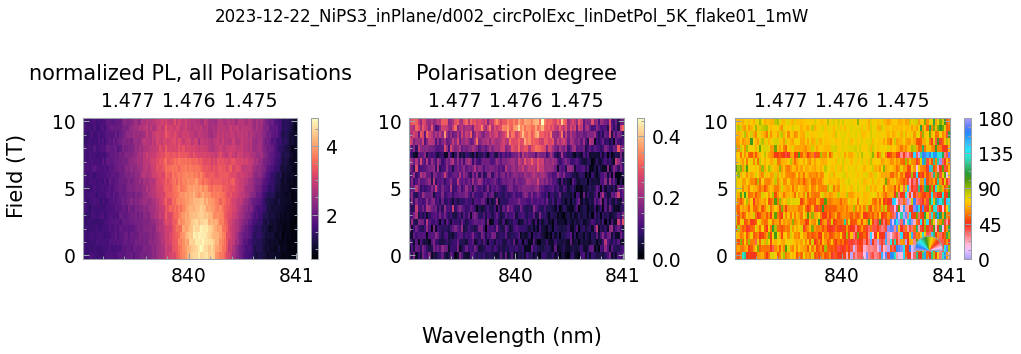

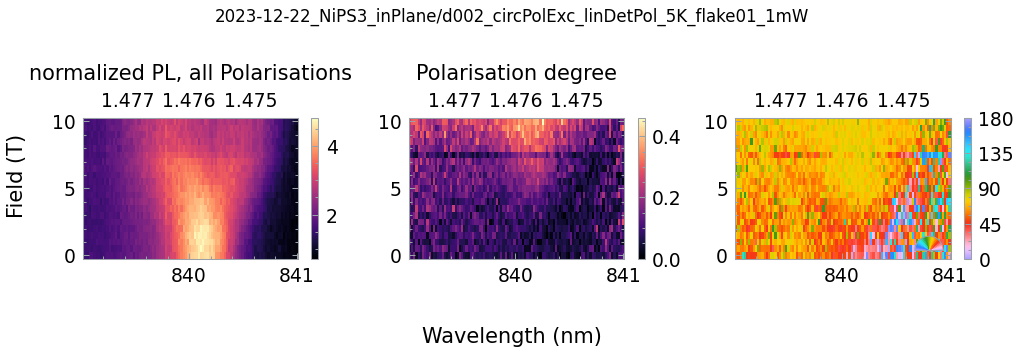

In [64]:
wavelength_slice = slice(839, 841)
# wavelength_slice = slice(838, 842)

def custom_polarisation(sel):
	sel = sel.coarsen(wavelength=sel.wavelength.shape[0]//80, boundary="trim").mean()
	# sel = sel.where(~np.isnan(sel), drop=True)
	pol = polarisation_xarray(sel.assign_coords(angle=2*sel.angle))
	pol = pol.sortby("field")
	return pol


def plot_fig(sel, save=False, wavelength_slice=wavelength_slice):
	pol = custom_polarisation(sel.sel(wavelength=wavelength_slice))
	fig = plt.figure(figsize=FIGSIZE_WIDE)
	plt.suptitle(sel.name)
	plt.subplot(131)
	plot.energy_ticks()
	(
		unploarized(sel.sortby("field").sel(wavelength=wavelength_slice))/
		unploarized(sel.sortby("field").sel(wavelength=wavelength_slice_norm)).mean("wavelength")
	).plot(
		add_labels=False, 
		add_colorbar=True,
		cmap=CMAP,
	 	rasterized=True
	)
	plt.title(r"normalized PL, all Polarisations")

	plt.subplot(132)
	plot.energy_ticks()
	pol.polarisation\
	.plot(
		vmin=0,
		add_labels=False,
		cmap=CMAP,
		rasterized=True
	)
	plt.title("Polarisation degree")

	ax = plt.subplot(133)
	ax.set_facecolor("black")
	plot.energy_ticks()
	img = pol.angle\
	.plot(
		vmin=0, vmax=180,
		cmap=cm["CET_C6s"],
		add_labels=False,
		add_colorbar=False,
  		rasterized=True
	)
	plt.colorbar(img).ax.set_yticks(np.arange(0, 181, 45))
	plot.inset_cbar_polar(img.cmap)

	# plt.title(r"$\measuredangle P,H$")

	fig.supxlabel("Wavelength (nm)", fontsize=FONTSIZE)
	fig.supylabel("Field (T)", fontsize=FONTSIZE)

	if save:
		fig.savefig(f"../report/figures/2023-12-10 splitting polarisation on {sel.name.replace(r'/',' ')}.pdf")
		fig.savefig(f"../figures/2023-12-10 splitting polarisation on {sel.name.replace(r'/',' ')}.png")

	return fig

sel_mult = [
	# first round of measurements
	data[4] - data[4].min(),
	data[6],
	data[11],

	# second round
	data[33],
	xr.concat((data[34],data[35]), "field").sortby("field"),
	data[36],
	data[37],
	data[38]
]
# for s in sel_mult: 	plot_fig(s, save=False)
# plot_fig(sel_mult[0])

sel = [d for d in data if "Ni" in d.name and "in" in d.name]
sel = sel[-2]
pprint({i:s.name for i,s in enumerate(data) if s.name == sel.name})
plot_fig(sel, save=True)

In [44]:
sel =  [d for d in data if "Ni" in d.name and "inPlane" in d.name and ("linPol" in d.name or "linDet" in d.name)]
pprint({i:d.name for i,d in enumerate(data) if d.name in [s.name for s in sel]})
sel = sel[11]
pprint(sel.name)

{6: '2023-12-06_LO_MG_NiPS3/d006_flake01_10K_inPlane_linPol',
 7: '2023-12-07_LO_MG_NiPS3/d001_flake06_50K_inPlane_linPol',
 8: '2023-12-07_LO_MG_NiPS3/d002_flake04_50K_inPlane_linPol_sweepDown',
 9: '2023-12-07_LO_MG_NiPS3/d005_flake04_50K_inPlane_linPol_sweepUp',
 10: '2023-12-07_LO_MG_NiPS3/d006_flake04_50K_inPlane_linPol_sweepDown',
 11: '2023-12-08_LO_MG_NiPS3/d001_flake04_50K_inPlane_linPol_sweepUp',
 12: '2023-12-08_LO_MG_NiPS3/d002_flake04_50K_inPlane_linPol_hysteresis',
 15: '2023-12-11_NiPS3/d003_flake04_50K_linPol_inPlane',
 37: '2023-12-20_NiPS3_inPlane/d001_circPolExc_linDetPol_10K_flake02_2mW',
 38: '2023-12-20_NiPS3_inPlane/d003_circPolExc_linDetPol_10K_flake02_2mW_smallerSlit',
 39: '2023-12-20_NiPS3_inPlane/d005_circPolExc_linDetPol_10K_flake08_2mW_smallerSlit_filmBeamsplitter',
 40: '2023-12-20_NiPS3_inPlane/d006_circPolExc_linDetPol_10K_flake08_2mW_smallerSlit',
 41: '2023-12-21_NiPS3_inPlane/d002_circPolExc_linDetPol_50K_flake01_1mW',
 42: '2023-12-22_NiPS3_inPlane/

## out of plane

### Circ Dichroism

KeyboardInterrupt: 

/home/leon/Projekte/Studium/2023_WS/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84187/ev


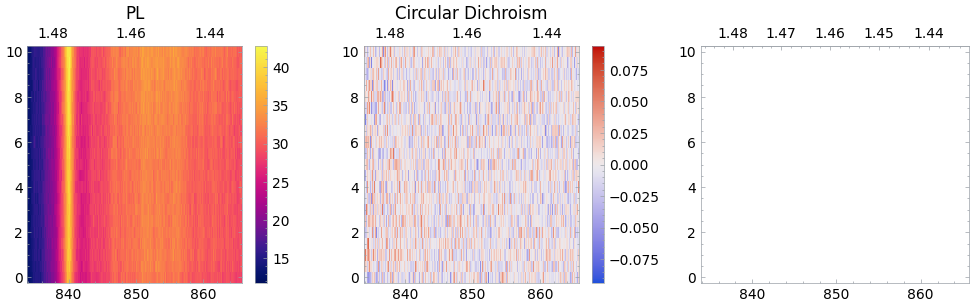

In [26]:
# plot the circular dichroism
sel = data[14]
assert len(sel.angle) == 2

def pre(sel):
	d =  sel.rolling(wavelength=1).mean()
	d = d.sel(wavelength=wavelength_slice)
	return d

fig = plt.figure(figsize=FIGSIZE_WIDE)
ax = plt.subplot(131)
plot.energy_ticks()
pre(sel).mean("angle").plot(
	cmap=cm["CET_L8"],
	add_labels=False
)
plt.title("PL")

ax = plt.subplot(132, sharex=ax, sharey=ax)
plot.energy_ticks()
dichroism(pre(sel)).plot(
	cmap=cm["CET_D1"],
	add_labels=False,
	# vmin=-1, vmax=1,
	
)
plt.title("Circular Dichroism")

ax = plt.subplot(133, sharex=ax, sharey=ax)
plot.energy_ticks()
pol = polarisation_xarray(pre(data[15]))
pol.polarisation.plot(
	add_labels=False,
	cmap=cm["CET_L8"],
	vmin=0, vmax=1,
)
plt.title("Linear Dichroism")

fig.supxlabel("Wavelength (nm)", fontsize=FONTSIZE)
fig.supylabel("Field (T)", fontsize=FONTSIZE)

# plt.savefig(f"../report/figures/2023-12-10 circular dichroism {sel.name.replace('/',  ' ')}.pdf")

plt.show()

## Second round

### selected Flakes

In [25]:
paths = glob("../data/2023-12-18*/*_210K.tiff")
paths = [p for p in paths if "flake07" in p]
name = np.array([p.split("/")[-1].split("_")[0].split("flake")[-1].replace("and", ", ") for p in paths])
coords = np.array([p.split("/")[-1].split("_210K")[0].split("_")[1:4] for p in paths]).astype(float)
images = xr.DataArray(
	[plt.imread(p) for p in paths],
	dims=["image", "x", "y"]
)

pixel_per_um = np.linalg.norm(find_shift(images))/np.linalg.norm(np.diff(coords[:, :2], axis=0))

images[:, 200:350, 275:400].plot(col="image", cmap=cm["CET_L8"])

NameError: name 'find_shift' is not defined

In [24]:
# selected flakes
# find pixels per um using reference images
paths = glob("../data/2023-12-18*/*_210K.tiff")
paths = [p for p in paths if "flake07" in p]
name = np.array([p.split("/")[-1].split("_")[0].split("flake")[-1].replace("and", ", ") for p in paths])
coords = np.array([p.split("/")[-1].split("_210K")[0].split("_")[1:4] for p in paths]).astype(float)
images = xr.DataArray(
	[plt.imread(p) for p in paths],
	dims=["image", "x", "y"]
)
pixel_per_um = np.linalg.norm(find_shift(images))/np.linalg.norm(np.diff(coords[:, :2], axis=0))

# import all images
paths = glob("../data/2023-12-18*/*_210K.tiff")

name = np.array([p.split("/")[-1].split("_")[0].split("flake")[-1].replace("and", ", ") for p in paths])
coords = np.array([p.split("/")[-1].split("_210K")[0].split("_")[1:4] for p in paths]).astype(float)

name, idx = np.unique(name, return_index=True)
coords = coords[idx]
paths = np.array(paths)[idx]

images = xr.DataArray(
	[plt.imread(p) for p in paths],
	coords={
		"flake": name,
	},
	dims=["flake", "x", "y"]
)
images = images.assign_coords(
	x= images.x / pixel_per_um,
	y= images.y / pixel_per_um,
)

plt.figure()
plt.plot(coords[:, 0], coords[:, 1], "o")
for i, (c, n) in enumerate(zip(coords, name)):
	plt.annotate(n, c[0:2], fontsize=FONTSIZE_SMALL)

plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.show()

NameError: name 'find_shift' is not defined

In [ ]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
plt.figure()
img = images[:, 150:350, 200:400].plot(col="flake", col_wrap=5)
for a in img.axs.flatten():
	a.set_yticks([])
	a.set_xticks([])
	a.set_xlabel("")
	a.set_ylabel("")

	# a = img.axs.flatten()[0]
	scalebar = AnchoredSizeBar(a.transData,
		10, '10 um', 'lower right',
		frameon=False,
		pad=0,
		size_vertical=1,
	)

	a.add_artist(scalebar)

plt.show()

## Third round, new sample, better Setup

In [ ]:
positions

In [22]:
paths = glob("../data/2023-12-21*/*.tiff")
paths.sort()
images = [
	xr.DataArray(
		plt.imread(p),
		attrs={
			"position": np.array(p.split("/")[-1].split("_")[2:5]).astype(float),
		},
		name=p.split("data/")[-1].split(".tif")[0]
	)
	for p in paths
]

sel = [
	i for i in images if 
	("2023-12-21" in i.name and "i001" in i.name)
	or ("2023-12-21" in i.name and "i003" in i.name)
]

# calculate the shift between the images
# pixel_per_um = 75/np.linalg.norm(np.diff([s.position for s in sel], axis=0))
pixel_per_um = 80/np.diff([s.attrs["position"] for s in sel], axis=0)[0, 0]

# apply the shift to all images
for i in images:
	i.coords["x"] = i.coords["dim_0"] / pixel_per_um
	i.coords["y"] = i.coords["dim_1"] / pixel_per_um

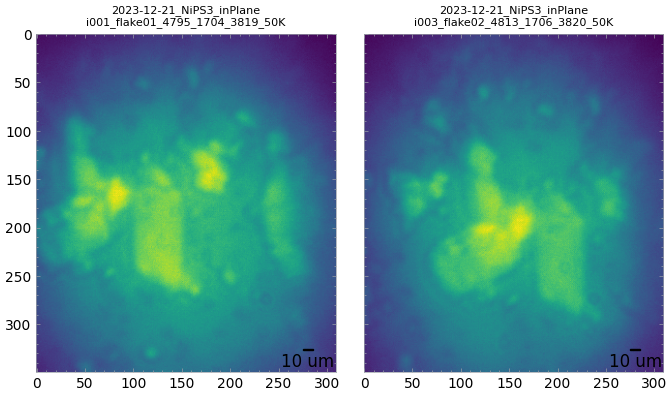

In [23]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

col = 2
fig, axs = plt.subplots(len(sel)//col, col, sharex=True, sharey=True, figsize=FIGSIZE_HUGE)

sel = images
sel = [
	i for i in images if 
	("2023-12-21" in i.name and "i001" in i.name)
	or ("2023-12-21" in i.name and "i003" in i.name)
]

for a, i in zip(axs.flatten(), sel):
	a.imshow(i[0:350, 190:500], cmap='viridis')
	# a.set_yticks([])
	# a.set_xticks([])
	a.set_xlabel("")
	a.set_ylabel("")
	a.title.set_text(i.name.replace("/", "\n"))
	a.title.set_fontsize(FONTSIZE_TINY)

	scalebar = AnchoredSizeBar(a.transData,
							   10, '10 um', 'lower right',
							   frameon=False,
							   pad=0,
							   size_vertical=1)
	a.add_artist(scalebar)

plt.tight_layout()
plt.show()

# CrPS4

In [ ]:
pprint({i:d.name for i, d in enumerate(data) if "CrPS4" in d.name})
wavelength_slice = slice(909, 917)

## Out of Plane

['2023-12-13_CrPS4_outPlane/d007_circPolDet_linExcPol_50K_3x3s_flake03',
 '2023-12-14_CrPS4_outPlane/d001_circPolDet_linExcPol_10K_5x5s_flake01_1mW',
 '2023-12-14_CrPS4_outPlane/d009_circPolDet_linExcPol_10K_flake03_4mW',
 '2023-12-15_CrPS4_inPlane/d002_circPolDet_linExcPol_10K_flake03_4mW']


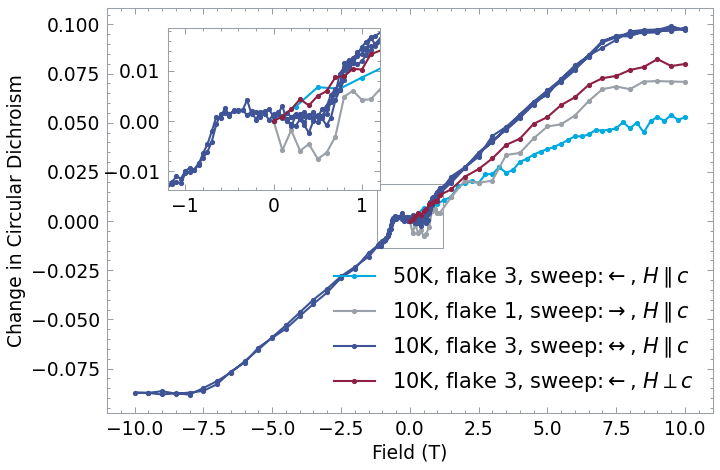

In [58]:
wavelength_slice = slice(910,915)

def pre(sel):
	ret = dichroism(
		sel.mean("wavelength")
	)
	ret = ret - ret.drop_duplicates("field").sel(field=0)
	return ret

plt.figure()

ax = plt.subplot()
axi = ax.inset_axes([0.1, 0.55, 0.35, 0.4])

sel_mult = [
	data[21],
	data[23],
	data[27],
	data[29]
]

pprint([d.name for d in sel_mult])

for sel in sel_mult:
	for a in [ax, axi]:
		pre(sel).plot(
			ax=a,
			marker=".",
			# label=sel.name,
			label = sel.name.split("K_")[0].split("_")[-1] + "K, "\
			+ f'flake {int(sel.name.split("flake")[-1].split("_")[0])}, '\
			+ "sweep:" + (
				r"$\rightarrow$" if sel.field_direction>0 else (
					r"$\leftarrow$" if sel.field_direction<0 else r"$\leftrightarrow$"
				)
			)
			+ ", " + (
				r"$H\parallel c$" if "out" in sel.name else r"$H\perp c$"
			)
			,

		)

ax.set_ylabel("Change in Circular Dichroism")
axi.set_ylabel("")
axi.set_xlabel("")

# set axi xlimits to -1,1 and ylimits automatically
field_slice = slice(-1.2, 1.2)
cd_boundary = (
	np.min([pre(d).sortby("field").sel(field=field_slice).min() for d in sel_mult])*1.1,
	np.max([pre(d).sortby("field").sel(field=field_slice).max() for d in sel_mult])*1.1
)
axi.set_xlim(field_slice.start, field_slice.stop)
axi.set_ylim(*cd_boundary)

# draw a rectangle
ax.add_patch(
	mpl.patches.Rectangle(
		(field_slice.start, cd_boundary[0]),
		field_slice.stop - field_slice.start,
		cd_boundary[1] - cd_boundary[0],
		linewidth=.5, edgecolor=SEEGRAU, facecolor='none'
	)
)

ax.set_xlabel("Field (T)")

ax.legend(loc="lower right")
plt.savefig("../figures/2023-12-14 circular dichroism measurement.png")
plt.savefig("../report/figures/2023-12-14 CrPS4 circular dichroism.pdf")
plt.show()

{0: '2023-12-13_CrPS4_outPlane/d007_circPolDet_linExcPol_50K_3x3s_flake03',
 1: '2023-12-14_CrPS4_outPlane/d001_circPolDet_linExcPol_10K_5x5s_flake01_1mW',
 2: '2023-12-14_CrPS4_outPlane/d009_circPolDet_linExcPol_10K_flake03_4mW',
 3: '2023-12-15_CrPS4_inPlane/d002_circPolDet_linExcPol_10K_flake03_4mW'}


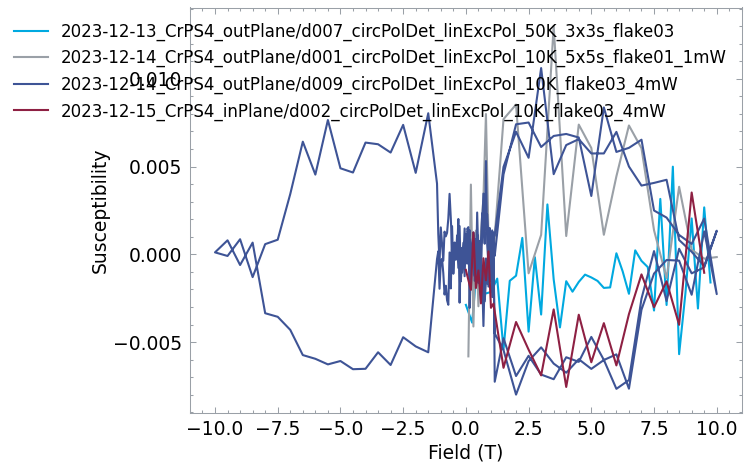

In [129]:
sel_mult = [d for d in data if "CrPS4" in d.name and "circPolDet" in d.name and 0. in d.field]

sel_mult = sel_mult[:1] + sel_mult[2:]

pprint({i:d.name for i,d in enumerate(sel_mult)})

plt.figure()
for sel in sel_mult:
    sel = pre(sel)
    # sel = sel.rolling(field=2).mean()
    sel = sel.diff("field")
    sel.plot(label=sel.name, _labels=False)
plt.legend(fontsize=FONTSIZE_TINY)
plt.xlabel("Field (T)")
plt.ylabel("Susceptibility")
plt.show()

{0: '2023-12-13_CrPS4_outPlane/d007_circPolDet_linExcPol_50K_3x3s_flake03',
 1: '2023-12-14_CrPS4_outPlane/d009_circPolDet_linExcPol_10K_flake03_4mW',
 2: '2023-12-15_CrPS4_inPlane/d002_circPolDet_linExcPol_10K_flake03_4mW'}


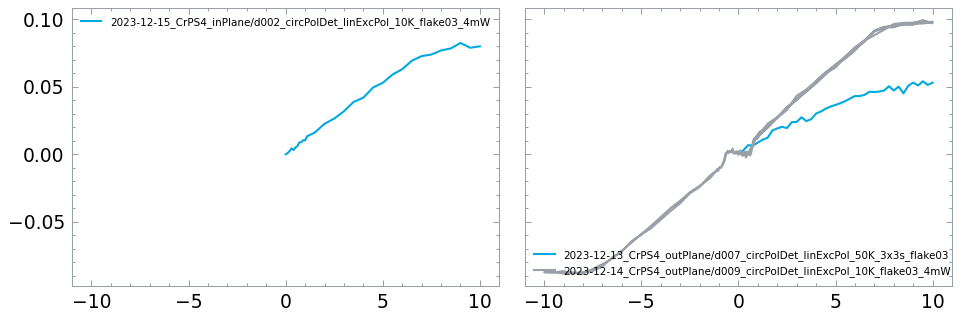

In [130]:
sel_mult = [d for d in data if "CrPS4" in d.name and "circPolDet" in d.name and 0. in d.field and "d008" not in d.name and "flake01" not in d.name]
pprint({i:d.name for i,d in enumerate(sel_mult)})

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=FIGSIZE_WIDE)

for sel in [d for d in sel_mult if "inPlane" in d.name]:
    pre(sel).plot(label=sel.name, _labels=False, ax=axs[0])
axs[0].legend(fontsize=5)


for sel in [d for d in sel_mult if "outPlane" in d.name]:
    pre(sel).plot(label=sel.name, _labels=False, ax=axs[1])
axs[1].legend(fontsize=5)

plt.show()

{0: '2023-12-13_CrPS4_outPlane/d007_circPolDet_linExcPol_50K_3x3s_flake03',
 1: '2023-12-14_CrPS4_outPlane/d001_circPolDet_linExcPol_10K_5x5s_flake01_1mW',
 2: '2023-12-14_CrPS4_outPlane/d009_circPolDet_linExcPol_10K_flake03_4mW',
 3: '2023-12-15_CrPS4_inPlane/d002_circPolDet_linExcPol_10K_flake03_4mW'}


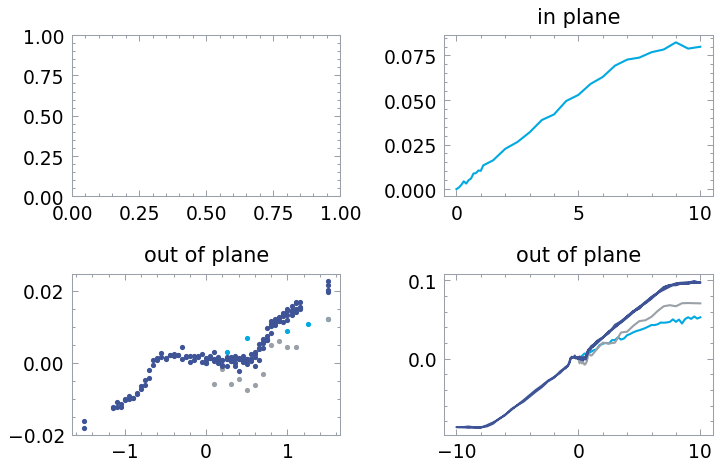

In [108]:
sel_mult = [d for d in data if "CrPS4" in d.name and "circPolDet" in d.name and 0. in d.field and "d008" not in d.name]
pprint({i:d.name for i,d in enumerate(sel_mult)})

fig, axs = plt.subplots(2, 2)

ax=axs[0,1]
for sel in [d for d in sel_mult if "inPlane" in d.name]:
    pre(sel).plot(label=sel.name, _labels=False, ax=ax)
# ax.legend(fontsize=5)
ax.set_title("in plane")


ax=axs[1,1]
for sel in [d for d in sel_mult if "outPlane" in d.name]:
    pre(sel).plot(label=sel.name, _labels=False, ax=ax)
ax.set_title("out of plane")
# ax.legend(fontsize=5)

ax=axs[1,0]
for sel in [d for d in sel_mult if "outPlane" in d.name]:
    sel = sel.sortby("field").sel(field=slice(-1.5, 1.5))
    pre(sel).plot(label=sel.name, _labels=False, ax=ax, marker=".", linestyle="none")
# ax.legend(fontsize=5)
ax.set_title("out of plane")


plt.show()

'2023-12-15_CrPS4_inPlane/d002_circPolDet_linExcPol_10K_flake03_4mW'


/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


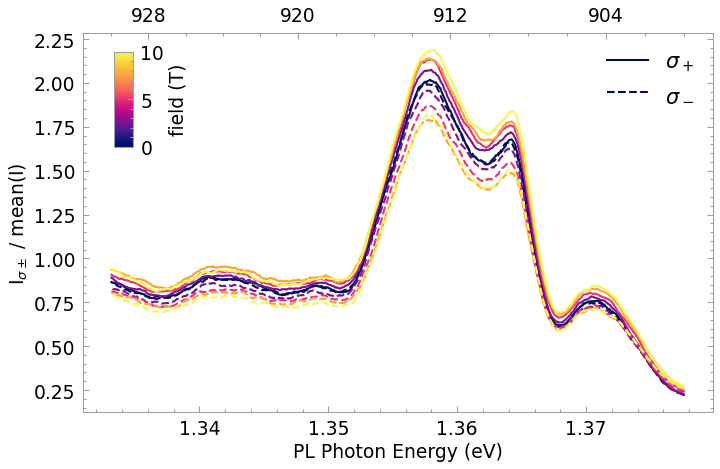

In [11]:
fields = np.linspace(0, 10, 5)
colors = cm["CET_L8"](fields/fields.max())

pprint(sel.name)

plt.figure()
for f, c in zip(fields, colors):
    s = sel.interp(field=f)
    s = s.rolling(wavelength=10).mean()
    s = s.sel(wavelength=slice(900, 930))
    s = s/s.mean()

    s.isel(angle=0).plot(x="energy", color=c, _labels=False)
    s.isel(angle=-1).plot(x="energy", color=c, _labels=False, linestyle="--")

plt.legend(
    ["$\sigma_+$", "$\sigma_-$"],
)

# add colorbar with field
cax = plt.gca().inset_axes([0.05, 0.7, 0.03, 0.25])
sm = plt.cm.ScalarMappable(cmap=cm["CET_L8"], norm=plt.Normalize(vmin=0, vmax=10))
plt.colorbar(sm, cax=cax, label=r"field (T)")

plot.energy_ticks()
plt.xlabel("PL Photon Energy (eV)")
plt.ylabel("I$_{\sigma\pm}$ / mean(I)")
# plt.savefig("../report/figures/2024-04-07 CrPS4 spectrum.pdf")
plt.show()

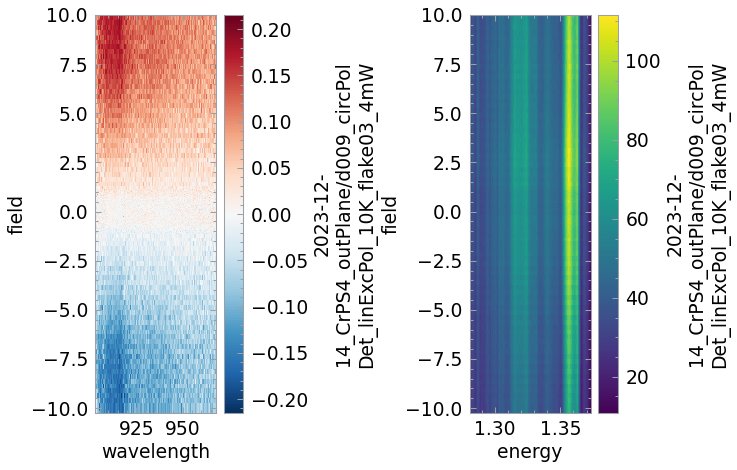

In [12]:
plt.figure()
sel = sel_mult[1].sortby("field")
sel = sel-sel.min()
sel = sel.sel(wavelength=slice(903,None))
plt.subplot(121)
dichroism(sel).plot()
plt.subplot(122)
sel.mean("angle").plot(x="energy", y="field")

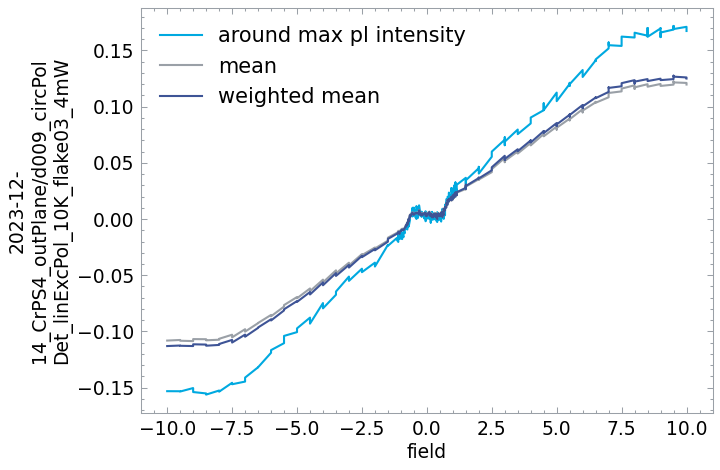

In [13]:
plt.figure()
dichroism(sel).rolling(wavelength=15).mean().sel(wavelength=sel.mean("angle").idxmax("wavelength")).plot(label="around max pl intensity")
dichroism(sel).mean("wavelength").plot(label="mean")
# weighted mean
dichroism(sel).weighted(sel.mean("angle")).mean("wavelength").plot(label="weighted mean")
plt.legend()

## flake turning
<table>
<tr>
<th><img src="../data/2023-12-13_CrPS4/flake01_4425_3360.bmp" width=300px/></th>
<th><img src="../data/2023-12-13_CrPS4/flake01_4425_3360_after cooldown to 10K_croped.bmp" width=300px/></th>
</tr></table>
<img src="../data/2023-12-14_CrPS4/flake03_rotation_cropped.png" width=600px>

**Left**: flake 01, cooled down to 50K, **Right**: flake01, cooled down to 10K  
**Bottom**: flake 03 at 10K, inset 50K rotation matched to polarisation

Field was also applied out of plane.

{17: '2023-12-13_CrPS4_outPlane/d002_linPolDet_50K',
 18: '2023-12-13_CrPS4_outPlane/d004_linPolDet_circExcPol_50K_3x3s_flake01',
 19: '2023-12-13_CrPS4_outPlane/d005_linPolDet_circExcPol_50K_3x3s_flake02',
 20: '2023-12-13_CrPS4_outPlane/d006_linPolDet_circExcPol_50K_3x3s_flake03',
 25: '2023-12-14_CrPS4_outPlane/d005_linPolDet_circExcPol_10K_flake01_0.6mW',
 26: '2023-12-14_CrPS4_outPlane/d007_linPolDet_circExcPol_10K_flake03_3.3mW',
 28: '2023-12-15_CrPS4_inPlane/d001_linPolDet_circExcPol_10K_flake03_4mW'}


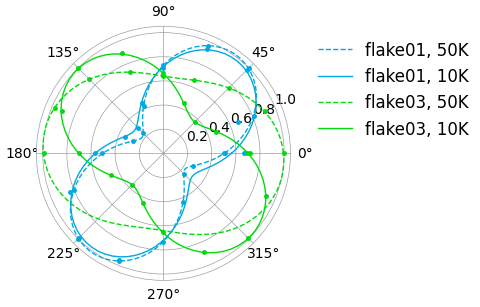

In [90]:
pprint({i:d.name for i, d in enumerate(data) if "CrPS4" in d.name and "linPolDet" in d.name})

wavelength_slice = slice(909, 917)

def pre(d):
	ret = d.isel(field=0)\
	.rolling(wavelength=10).mean()\
	.sel(wavelength=wavelength_slice).max("wavelength")\
	.assign_coords(angle=d.angle*np.pi/180 *2)
	return ret/ret.max()

plt.figure()
ax = plt.subplot(111, projection="polar")
sel_mult = np.array(data, dtype=object)[[18, 25, 20, 26]]

color = {
	"flake01": "C0",
	"flake03": "C1",
}
kind = {
	"50K": "--",
	"10K": "-",
}



for i, sel in enumerate(sel_mult):
	label =  (
			"flake" + sel.name.split("flake")[-1].split("_")[0],
			sel.name.split("K")[0].split("_")[-1] + "K"
		)
	mark = pre(sel).plot(ax=ax, _labels=None,
		linestyle="none",
		marker="o", markersize=2.5,
		color=color[label[0]],
	)
	popt, _ = fit_cos_sqr(sel.angle*2, pre(sel).values)
	angle = np.linspace(0, 360, 100)
	ax.plot(angle*np.pi/180, cos_sqr(angle, *popt), color=mark[0].get_color(),
		linestyle=kind[label[1]],
		label=f"{label[0]}, {label[1]}",
	)
	
plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig("../report/figures/2023-12-14 flake turning linear polarisation.pdf")
plt.show()

In [ ]:
def plot_peanuts(sel, ax):
	for d in sel:
		d = d.isel(field=0)
		d = d.rolling(wavelength=5).mean().max("wavelength")
		d = d[1:]
		d -= d.min()
		d = d / d.max()
		points = d.assign_coords(angle=lambda x: x.angle * np.pi/180 *2).plot(
			ax=ax,_labels=False,
			linestyle="none", marker="o", markersize=3
		)
		popt, _  = fit_cos_sqr(d.angle*2, d)
		x = np.linspace(0, 2*np.pi, 100)
		ax.plot(x, cos_sqr(x*180/np.pi, *popt), 
			color = points[0].get_color(),
			label=d.name.split("K")[-2].split("_")[-1] + " K"
		)

		# add a rotation arrow
		ax.plot(
			(popt[1]% 180)*np.pi/180, 1.1,
			"x", color = points[0].get_color(),
			ms=10
		)

sel = [data[18], data[25], data[20], data[26]]
groups = groupby_list(sel, lambda x: x.attrs["name"].split("flake")[1].split("_")[0])

flakes = len(list(groups))

fig, axs = plt.subplots(1, flakes,  subplot_kw={'projection': 'polar'}, figsize=FIGSIZE_WIDE)
fig.suptitle(sel[0].name, fontsize=FONTSIZE_TINY)
axs = axs.flatten()

for ax, (name, sel) in zip(axs, groups):
	plot_peanuts(sel, ax)
 
axs[-1].legend(
	bbox_to_anchor=(1.5, 1.1),
)

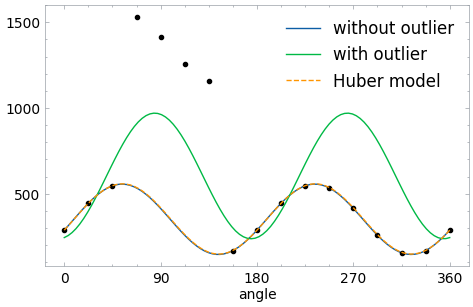

In [ ]:
from sklearn.linear_model import HuberRegressor, LinearRegression

sel = data[18].mean("wavelength").sel(field=0)
sel = sel.assign_coords(angle=sel.angle*2)


plt.figure()
plt.xticks(np.arange(0,361,90))
plt.locator_params(nbins=5)
plt.xlabel("angle")

angle = np.linspace(0, 360, 100)

# non linear fit
# def model(x, a,b,delta): return a * np.cos(x*np.pi/180 - delta)**2 + b
# popt, _ = sp.optimize.curve_fit(model, sel.angle, sel.values)         # approx 25 ms
# plt.plot(angle, model(angle, *popt), label="curve_fit")

# linar model
def model_linear(x, a,b,c):  return a* np.cos(2*x*np.pi/180) + b* np.sin(2*x*np.pi/180) + c
popt, _ = sp.optimize.curve_fit(model_linear, sel.angle, sel.values)
from sklearn.linear_model import Huber, LinearRegression
reg = LinearRegression()
x = np.cos(2*sel.angle*np.pi/180)
y = np.sin(2*sel.angle*np.pi/180)
X = np.column_stack((x, y))
reg.fit(X, sel.values)  # .5 ms
(a,b), c = reg.coef_, reg.intercept_
plt.plot(angle, model_linear(angle, a,b,c), label="without outlier")

# add an outlier
sel[3:7] += 1000

sel.plot(linestyle="none", marker="o", _labels=None, color="k")

# linar model
def model_linear(x, a,b,c):  return a* np.cos(2*x*np.pi/180) + b* np.sin(2*x*np.pi/180) + c
popt, _ = sp.optimize.curve_fit(model_linear, sel.angle, sel.values)
reg = LinearRegression()
x = np.cos(2*sel.angle*np.pi/180)
y = np.sin(2*sel.angle*np.pi/180)
X = np.column_stack((x, y))
reg.fit(X, sel.values)  # .5 ms
(a,b), c = reg.coef_, reg.intercept_
plt.plot(angle, model_linear(angle, a,b,c), label="with outlier")

# add a robust detection
reg = HuberRegressor()
reg.fit(X, sel.values) # 8ms
(a,b), c = reg.coef_, reg.intercept_
plt.plot(angle, model_linear(angle, a,b,c), label="Huber model", linestyle="--")


# plt.grid()
plt.legend()
plt.show()

In [ ]:
import matplotlib
matplotlib.matplotlib_fname()

'/home/leon/.local/lib/python3.11/site-packages/matplotlib/mpl-data/matplotlibrc'

## linear out of plane

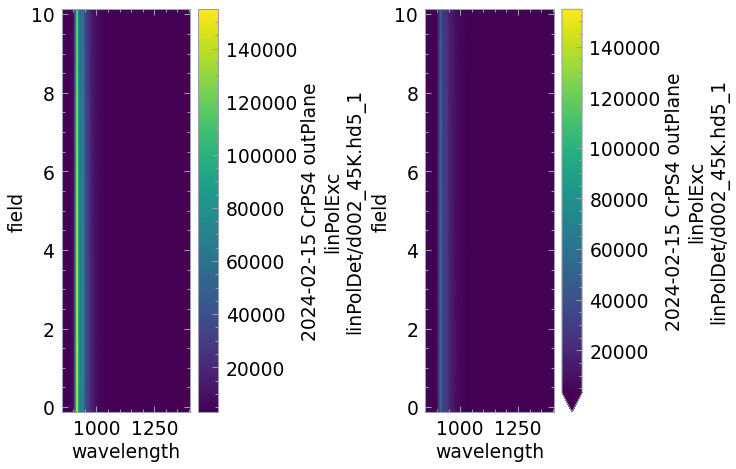

In [79]:
sel = [d for d in data if "CrPS4" in d.name and "linPolDet" in d.name and len(d.field)>1 and "out" in d.name]
plt.figure()

ax = plt.subplot(121)
img = sel[-2].max("angle").plot()
plt.subplot(122, sharex=ax, sharey=ax)
sel[-2].min("angle").plot(vmin=img.get_clim()[0], vmax=img.get_clim()[1])

In [1]:
# linear dichroism
sel = [d for d in data if "CrPS4" in d.name and "linPolDet" in d.name  and len(d.field)>1 and "out" in d.name]
pprint([i.name for i in sel])
sel = sel[-3].sortby("field")
print(sel.name)
assert len(sel.angle) > 3
assert len(sel.field) > 3
# wavelength_slice=slice(905, 920)
wavelength_slice=slice(880, 1100)
# wavelength_slice=slice(None, None)
sel = sel.sel(wavelength=wavelength_slice)


# downsample smoothly along wavelength
wavelength_n = 50
field_n = 20

sel = sel.where(~np.isnan(sel), drop=True)
pol = polarisation_xarray(
	sel\
	.rolling(wavelength=sel.wavelength.shape[0]//wavelength_n).mean()\
	.interp(wavelength=np.linspace(sel.wavelength.min(), sel.wavelength.max(), wavelength_n))\
	.interp(field=np.linspace(sel.field.min(), sel.field.max(), field_n))
	.assign_coords(angle=2*sel.angle)\
	.dropna("wavelength")
)

pol = pol.sortby("field")

fig = plt.figure(figsize=FIGSIZE_WIDE)
plt.suptitle(sel.name)
# plt.subplot(131)
# img = sel.sel(angle=0).plot(
# 	add_labels=False, 
# 	add_colorbar=False,
# 	cmap="magma",
# )
# plt.colorbar(img)
# plt.title(r"PL ($\parallel H$)")

plt.subplot(131)
plot.energy_ticks()
img = sel.sortby("field").mean("angle").plot(
	vmin=0,
	add_labels=False, 
	add_colorbar=False,
	cmap=cm["CET_L8"],
)
plt.colorbar(img)
plt.title(r"PL all Polarisations")

plt.subplot(132)
plot.energy_ticks()
pol.polarisation.plot(
	vmin=0,
	add_labels=False,
	cmap=cm["CET_L8"],
)
plt.title("Polarisation degree")

plt.subplot(133)
plot.energy_ticks()
img = (
	pol.angle
).plot(
	# vmin=0, vmax=180,
	# cmap=cm["CET_C6s"],
	# cmap=cm["CET_D1"],
	cmap=cm["CET_L8"],
	add_labels=False,
	add_colorbar=False,
)
cbar = plt.colorbar(img)#.ax.set_yticks(np.arange(0, 181, 45))
plt.title("Polarisation angle")
plot.inset_cbar_polar(img.cmap, clim=img.get_clim())


fig.supxlabel("Wavelength (nm)", fontsize=FONTSIZE)
fig.supylabel("Field (T)", fontsize=FONTSIZE)
plt.show()

plt.figure()
pol.angle.sel(wavelength=slice(900, 975)).mean("wavelength").plot()
plt.title(sel.name, fontsize=FONTSIZE_TINY)
# plt.savefig(f"../report/figures/2023-12-14 CrPS4 in plane linear dichroism mean 10K.pdf")

NameError: name 'data' is not defined

['2023-12-13_CrPS4_outPlane/d006_linPolDet_circExcPol_50K_3x3s_flake03',
 '2024-02-14 CrPS4 outPlane linPolExc linPolDet/d001_280K.hd5_6',
 '2024-02-14 CrPS4 outPlane linPolExc linPolDet/d002_100K.hd5_4',
 '2024-02-15 CrPS4 outPlane linPolExc linPolDet/d001_70K.hd5_5',
 '2024-02-15 CrPS4 outPlane linPolExc linPolDet/d002_45K.hd5_1',
 '2024-02-15 CrPS4 outPlane linPolExc linPolDet/d003_5K.hd5_1']


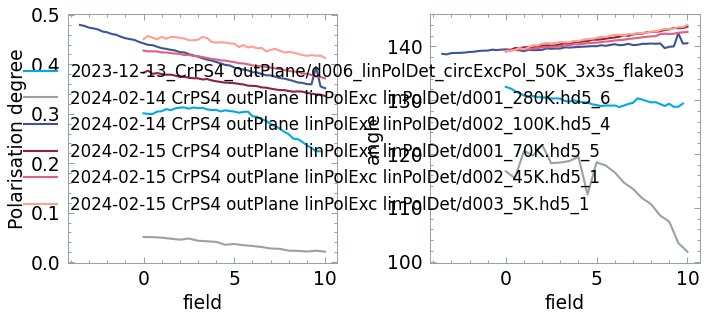

In [82]:
sel = [d for d in data if "CrPS4" in d.name and "linPolDet" in d.name  and len(d.field)>1 and "out" in d.name]
pprint([i.name for i in sel])
# sel = sel[-3].sortby("field")
# print(sel.name)

def pre(sel): return sel.sel(wavelength=slice(900, 975)).mean("wavelength")
pol = [polarisation_xarray(pre(red)) for red in sel]


fig = plt.figure(figsize=FIGSIZE_WIDE)
plt.subplot(121)
for p in pol: p.polarisation.plot()
plt.ylabel("Polarisation degree")
plt.subplot(122)
for p,s in zip(pol, sel): p.angle.plot(label=s.name)
plt.legend(fontsize=FONTSIZE_TINY)
plt.show()


['2023-12-15_CrPS4_inPlane/d001_linPolDet_circExcPol_10K_flake03_4mW',
 '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d001_200K.hd5_1',
 '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d001_45K.hd5_1',
 '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d001_55K.hd5',
 '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d001_5K.hd5',
 '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d002_100K_hysteresis.hd5_1',
 '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d002_30K_hysteresis.hd5_3']


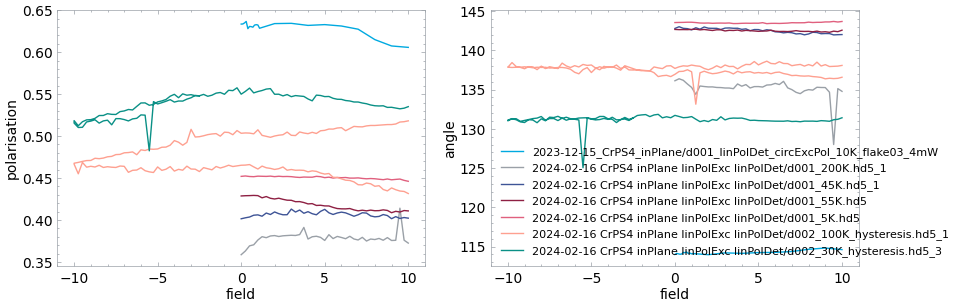

In [11]:
sel = [d for d in data if "CrPS4" in d.name and "linPolDet" in d.name  and len(d.field)>1 and "inPlane" in d.name]
pprint([i.name for i in sel])
# sel = sel[-3].sortby("field")
# print(sel.name)

def pre(sel): return sel.sel(wavelength=slice(900, 975)).mean("wavelength")
pol = [polarisation_xarray(pre(red)) for red in sel]


fig = plt.figure(figsize=FIGSIZE_WIDE)
plt.subplot(121)
for p in pol: p.polarisation.plot()
plt.subplot(122)
for p,s in zip(pol, sel): p.angle.plot(label=s.name)
plt.legend(fontsize=FONTSIZE_TINY)
plt.show()


## In Plane

{0: '2023-12-15_CrPS4_inPlane/d001_linPolDet_circExcPol_10K_flake03_4mW',
 1: '2023-12-15_CrPS4_inPlane/d002_circPolDet_linExcPol_10K_flake03_4mW',
 2: '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d001_200K.hd5_1',
 3: '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d001_45K.hd5_1',
 4: '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d001_55K.hd5',
 5: '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d001_5K.hd5',
 6: '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d002_100K_hysteresis.hd5_1',
 7: '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d002_30K_hysteresis.hd5_3'}
selected:	2024-02-16 CrPS4 inPlane linPolExc linPolDet/d002_100K_hysteresis.hd5_1


/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


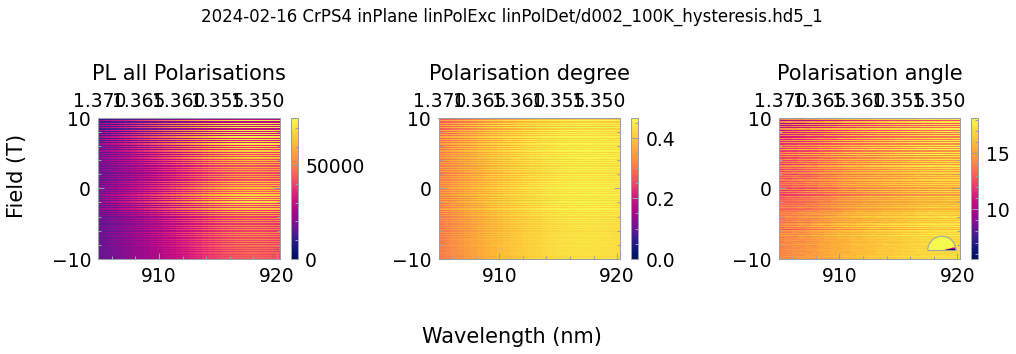

In [91]:
# linear dichroism
sel = [d for d in data if "CrPS4" in d.name and "inPlane" in d.name]
pprint({i:d.name for i, d in enumerate(sel)})
sel = sel[-2]
print(f"selected:\t{sel.name}")


assert len(sel.angle) > 3
wavelength_slice=slice(905, 920)
# wavelength_slice=slice(None, None)
sel = sel.sel(wavelength=wavelength_slice)


# downsample smoothly along wavelength
wavelength_n = 50
field_n = 20

sel = sel.where(~np.isnan(sel), drop=True)
# pol = polarisation_xarray(
# 	sel\
# 	.rolling(wavelength=sel.wavelength.shape[0]//wavelength_n).mean()\
# 	.interp(wavelength=np.linspace(sel.wavelength.min(), sel.wavelength.max(), wavelength_n))\
# 	.interp(field=np.linspace(sel.field.min(), sel.field.max(), field_n))
# 	.assign_coords(angle=2*sel.angle)\
# 	.dropna("wavelength")
# )
pol = polarisation_xarray(sel.assign_coords(angle=2*sel.angle))

pol = pol.sortby("field")

fig = plt.figure(figsize=FIGSIZE_WIDE)
plt.suptitle(sel.name)
# plt.subplot(131)
# img = sel.sel(angle=0).plot(
# 	add_labels=False, 
# 	add_colorbar=False,
# 	cmap="magma",
# )
# plt.colorbar(img)
# plt.title(r"PL ($\parallel H$)")

plt.subplot(131)
plot.energy_ticks()
img = sel.sortby("field").mean("angle").plot(
	vmin=0,
	add_labels=False, 
	add_colorbar=False,
	cmap=cm["CET_L8"],
	rasterized=True
)
plt.colorbar(img)
plt.title(r"PL all Polarisations")

plt.subplot(132)
plot.energy_ticks()
pol.polarisation.plot(
	vmin=0,
	add_labels=False,
	cmap=cm["CET_L8"],
	rasterized=True
)
plt.title("Polarisation degree")

plt.subplot(133)
plot.energy_ticks()
img = (
	pol.angle
).plot(
	# vmin=0, vmax=180,
	# cmap=cm["CET_C6s"],
	# cmap=cm["CET_D1"],
	cmap=cm["CET_L8"],
	add_labels=False,
	add_colorbar=False,
	rasterized=True
)
cbar = plt.colorbar(img)#.ax.set_yticks(np.arange(0, 181, 45))
plt.title("Polarisation angle")
plot.inset_cbar_polar(img.cmap, clim=img.get_clim())


fig.supxlabel("Wavelength (nm)", fontsize=FONTSIZE)
fig.supylabel("Field (T)", fontsize=FONTSIZE)

# plt.savefig(f"../report/figures/2023-12-15 CrPS4 linear dichroism.pdf")
plt.show()

Text(0.5, 1.0, '2024-02-16 CrPS4 inPlane linPolExc linPolDet/d002_100K_hysteresis.hd5_1')

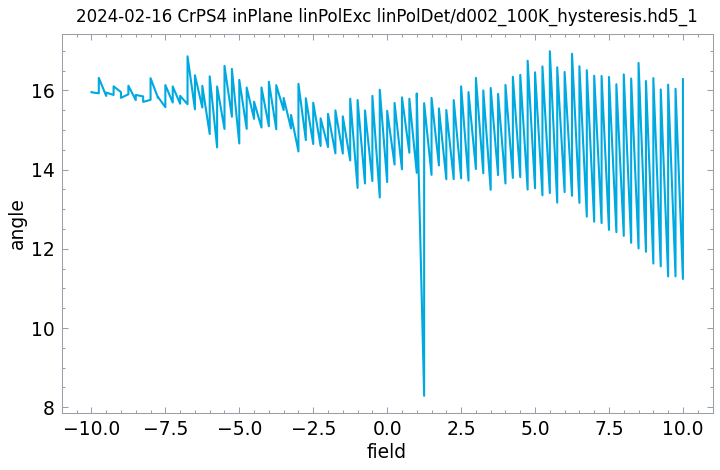

In [92]:
plt.figure()
pol.angle.mean("wavelength").plot()
plt.title(sel.name, fontsize=FONTSIZE_TINY)

compared to out of plane:   
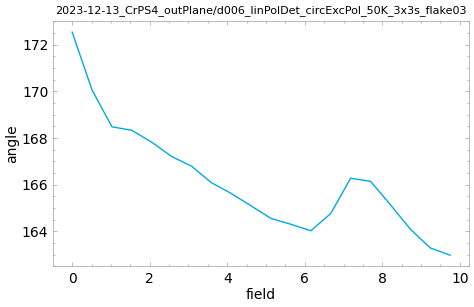

/home/leon/Projekte/Studium/2023_WS/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84187/ev


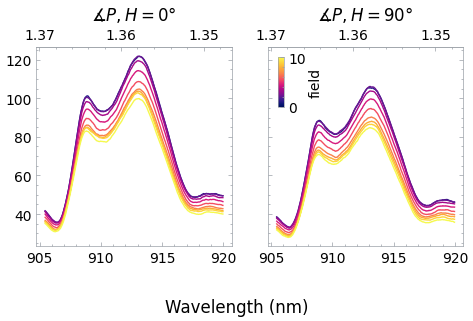

In [32]:
fig, axs = plt.subplots(1, len(angles), sharex=True, sharey=True)

field = np.linspace(0, 10, 10)
color = cm["CET_L8"](field / field.max())

def pre(d):
	d = d.\
	rolling(field=2).mean().\
	rolling(wavelength=10).mean().\
	sortby("field")
	# return d
	return d.sel(wavelength=wavelength_slice) #/ d.sel(wavelength=wavelength_slice_norm).mean("wavelength")

for ang, ax in zip(angles, axs):
	for f, c in zip(field, color):
		pre(sel).sel(angle=ang).interp(field=f).plot(
			ax=ax, 
			color=c,
			x="wavelength",
		)
	ax.set_title(fr"$\measuredangle P,H = {float(ang)*2:.0f}°$")
	ax.set_xlabel("")
	ax.set_ylabel("")
	plot.energy_ticks(ax)


fig.supxlabel("Wavelength (nm)", fontsize=FONTSIZE)


# add colorbar with field
sm = plt.cm.ScalarMappable(cmap=cm["CET_L8"], norm=plt.Normalize(vmin=0, vmax=10))
sm.set_array([])
# insert axs for colorbar into axs[-1]
cax = axs[-1].inset_axes([0.05, 0.7, 0.03, 0.25])
fig.colorbar(sm, cax=cax, label=r"field")
plt.tight_layout()

plt.show()

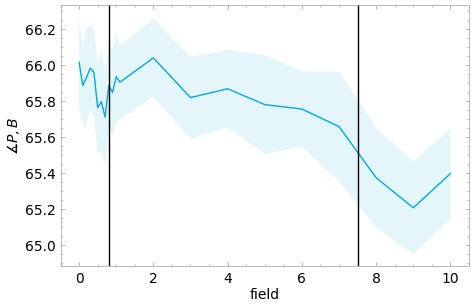

In [33]:
wavelength_slice = slice(905, 970)

sel = data[28]\
	.sel(wavelength=wavelength_slice)\
	.mean("wavelength")\
	.sortby("field")

pol = polarisation_xarray(sel)

plt.figure()
((90-pol.angle)%90).plot()
plt.fill_between(
	pol.field,
	((90-pol.angle)%90) - pol.angle_uncert,
	((90-pol.angle)%90) + pol.angle_uncert,
	alpha= .1
)
plt.axvline(.8, color="k")
plt.axvline(7.5, color="k")
plt.ylabel(r"$\measuredangle P, B$")
plt.show()

In [ ]:
{i:d.name for i,d in enumerate(data) if "Cr" in d.name and d.field.shape[0]>1}

ModuleNotFoundError: No module named 'numbagg'

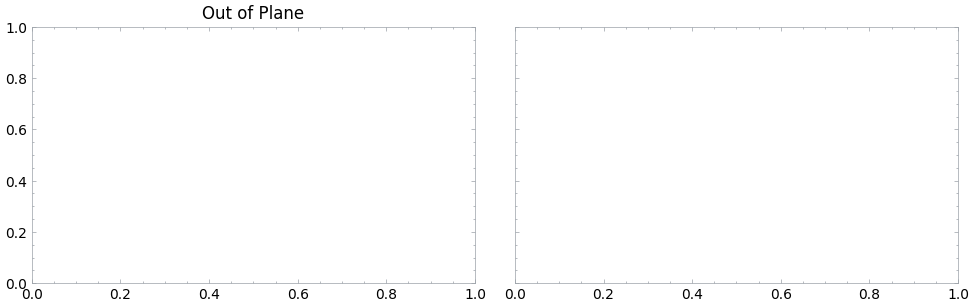

In [35]:
# circ dichroism
wavelength_slice = slice(None, None)

def pre(d):
	return d.rolling_exp(wavelength=10).mean()\
	.sel(wavelength=wavelength_slice)\
	.sortby("field")

def plot_fig(ax, sel):
	assert len(sel.angle) == 2

	if "inPlane" in sel.name:
		ax.set_title("In Plane")

	if "outPlane" in sel.name:
		ax.set_title("Out of Plane")

	# ax.set_title(sel.name, fontsize=FONTSIZE_TINY)
	dichroism(pre(sel)).plot(
		cmap=cm["CET_D1"],
		# cmap=cm["CET_L8"],
		# vmin=0,
		add_labels=False,
		ax=ax
	)

sel_mult = [
	data[27],
	data[29]
]

fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=FIGSIZE_WIDE)

for sel, ax, in zip(sel_mult, axs): plot_fig(ax, sel)


# fig.supxlabel("Wavelength (nm)", fontsize=FONTSIZE)
# fig.supylabel("Field (T)", fontsize=FONTSIZE)


plt.show()

## Reflection Spectra

In [ ]:
paths

(-1.0, 1.0)

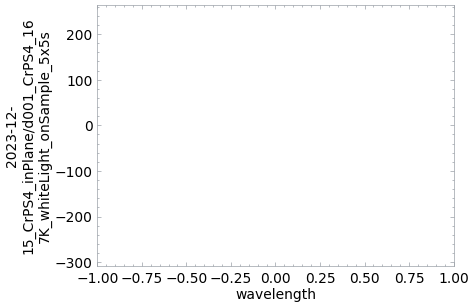

In [36]:
paths = glob("../data/2023-12-15*/d*.asc")
paths = [p for p in paths if "CrPS4" in p and "whiteLight" in p]

d = [custom_import_spectra(p) for p in paths]
d = [background_substract(d) for d in d]

d = [d.rolling(wavelength=15).mean() for d in d]

on = [d for d in d if "on" in d.name]
off = [d for d in d if "off" in d.name]

refl = []
for o, f in zip(on, off):
	f = f.interp(wavelength=o.wavelength)
	r = (f-o)/(f+o)
	r.attrs = o.attrs
	r.name = o.name
	refl.append(r)

plt.figure()
for r in refl:
	(r.diff("wavelength") / r).plot(label=r.name)
plt.xlim(-1,1)